# Does NDx replicate the biology?

In [75]:
import napari
from macrohet import dataio, tile, tools, visualise, colours
import os, glob
from tqdm.auto import tqdm
from skimage import io
import numpy as np
from macrohet.notify import send_sys_message as notify
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import zarr
import csv

palette = colours.expanded_piyg
sns.set_theme(style = 'white')
sns.set(font='Nimbus Sans', style = 'white')

# Define a function to remove outliers using IQR
def remove_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series >= lower_bound) & (series <= upper_bound)]
    
def calculate_time(row):
    if row['Expt. ID'] == 'PS0000':
        return row['Frame']
    else:
        return row['Frame'] / 2
import ast
# Assuming your DataFrame 'combined_df' looks like this with 'Acq. ID' as a string
# Create a small function to safely convert the string tuple
def parse_tuple(t):
    try:
        # Convert the string that looks like a tuple into an actual tuple
        return ast.literal_eval(t)
    except ValueError:
        # Return None or some form of error handling if conversion fails
        return None

import warnings
import pandas as pd
# Disable the FutureWarning related to use_inf_as_na
warnings.simplefilter(action='ignore', category=FutureWarning)
with pd.option_context('mode.use_inf_as_na', True):
    pass 

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

image_resolution = float('1.4949402023919043E-07') #float(metadata['ImageResolutionX'].iloc[0])
meters_area_per_pixel = image_resolution**2
mum_sq_scale_factor = (1E-6)**2
pixel_to_mum_sq_scale_factor = meters_area_per_pixel/mum_sq_scale_factor

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
expt_IDs = ['PS0000', 'ND0002', 'ND0003']

### Iterate over each image and find expression of RFP

In [3]:
output_dir = '/mnt/SYNO/macrohet_syno/manuscript/results/whole_fov_mtb_growth/'

In [4]:
Mtb_load_thresh = 480

In [105]:
for expt_ID in tqdm(expt_IDs):
    if expt_ID != 'ND0003':
        continue
    if expt_ID == 'PS0000':
        rfp_channel = 1
    else:
        rfp_channel = 0
    
    # se experiment dir
    base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
    # point to images 
    image_dir = os.path.join(base_dir, 'acquisition/zarr')
    # set output dir
    output_dir = os.path.join(base_dir, 'results/whole_fov_mtb_growth/raw_data')
    os.makedirs(output_dir, exist_ok=True)
    # load metadata
    metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
    assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
    # initiate empty rfp_df
    rfp_df = pd.DataFrame({}, columns = assay_layout.index)
    for acq_ID, data in tqdm(assay_layout.iterrows(), total = len(assay_layout), desc = f'Iterating over positions in {expt_ID}', leave = False):
        if os.path.exists(os.path.join(output_dir, f'RFP_signals_{acq_ID}.{expt_ID}.csv')):
            continue

        try:

            strain = data['Strain']
            compound = data['Compound']
            conc = data['Concentration']
            name = f'{strain, compound, conc}'
            row, column = acq_ID
            # load images
            image_fn = f'{image_dir}/{row, column}.zarr'
            images_zarr = zarr.open(image_fn, mode='r') 
            rfp_images = images_zarr.images[:,rfp_channel,...]
            rfp_images = np.max(rfp_images, axis = 1)
            
            rfp_signals = []
            for t in tqdm(range(0,len(rfp_images)), leave = False, desc = f'Iterating over frames in {acq_ID}, {expt_ID}'):
                try:
                    frame = rfp_images[t]
                    rfp_signal = np.count_nonzero(frame > Mtb_load_thresh)
                except Exception as e:
                    print(f'Could not load frame {t} row, col {acq_ID}')
                    print(e)
                    rfp_signal = None
                rfp_signals.append(rfp_signal)
            rfp_acq_ID_df = pd.DataFrame({'Frame': range(len(rfp_signals)), 
                                          'RFP_Signal': rfp_signals, 
                                          'Acq. ID':[acq_ID for i in range(len(rfp_signals))], 
                                          'Expt. ID':[expt_ID for i in range(len(rfp_signals))]})
            rfp_acq_ID_df.to_csv(os.path.join(output_dir, f'RFP_signals_{acq_ID}.{expt_ID}.csv'))
            # rfp_df[acq_ID] = rfp_signals
            
            # rfp_df.to_csv(os.path.join(output_dir, f'{expt_ID}_RFP_signals.csv'))

        except Exception as e:
            print(f"An error occurred: {e}")
            
            print(acq_ID, e)
            continue

  0%|          | 0/3 [00:00<?, ?it/s]

Reading metadata XML file...
Extracting metadata complete!


Iterating over positions in ND0003:   0%|          | 0/42 [00:00<?, ?it/s]

Iterating over frames in (5, 4), ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Iterating over frames in (5, 5), ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Iterating over frames in (5, 6), ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Iterating over frames in (5, 7), ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

Iterating over frames in (5, 8), ND0003:   0%|          | 0/154 [00:00<?, ?it/s]

### How many completed positions per experiment

In [5]:
pos_df_fns = []
for expt_ID in expt_IDs:
    path = f'/mnt/SYNO/macrohet_syno/{expt_ID}/results/whole_fov_mtb_growth/raw_data/*{expt_ID}.csv'
    fns = glob.glob(path)
    print(expt_ID, len(fns))
    pos_df_fns.extend(fns)

PS0000 24
ND0002 42
ND0003 42


# Compile multiexperiment dataframe into one

In [7]:
dataframes = []  # This list will store each DataFrame

for filename in pos_df_fns:
    
    # Load CSV file
    df = pd.read_csv(filename)
    
    # Drop 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    # print(os.path.basename(filename), df.keys())
    
    # Append the DataFrame to the list
    dataframes.append(df)
    
# Concatenate all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Apply the function to each row to create the new 'Time (hours)' column
combined_df['Time (hours)'] = combined_df.apply(calculate_time, axis=1)

assay_layouts = {}
for expt_ID in tqdm(expt_IDs):
    # se experiment dir
    base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
    metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
    assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
    assay_layouts[expt_ID] = assay_layout

# Prepare each assay layout DataFrame and store them in a list
prepared_layouts = []
for expt_id, df in assay_layouts.items():
    # Reset index to turn the MultiIndex into columns
    df = df.reset_index()
    # Add an 'Expt. ID' column to each DataFrame
    df['Expt. ID'] = expt_id
    prepared_layouts.append(df)

# Combine all individual DataFrame layouts into one DataFrame
assay_layout_df = pd.concat(prepared_layouts, ignore_index=True)

# Apply this function to the 'Acq. ID' column
combined_df['Acq. ID'] = combined_df['Acq. ID'].apply(parse_tuple)

# Now extract 'Row' and 'Column' from the actual tuple
combined_df['Row'] = combined_df['Acq. ID'].apply(lambda x: x[0] if x else None)
combined_df['Column'] = combined_df['Acq. ID'].apply(lambda x: x[1] if x else None)

prepared_layouts = []
for expt_id, df in assay_layouts.items():
    df = df.reset_index()
    df['Expt. ID'] = expt_id
    prepared_layouts.append(df)

# Combine into a single DataFrame
assay_layout_df = pd.concat(prepared_layouts, ignore_index=True)

# Merge combined_df with assay_layout_df
combined_df = pd.merge(combined_df, assay_layout_df, on=['Expt. ID', 'Row', 'Column'], how='left')

combined_df['Total Mtb Area (µm)'] = combined_df['RFP_Signal']  * pixel_to_mum_sq_scale_factor
del combined_df['RFP_Signal']

df = combined_df

df

  0%|          | 0/3 [00:00<?, ?it/s]

Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Frame Acq. ID Expt. ID  Time (hours)  Row  Column Strain Compound  \
0          0  (3, 5)   PS0000           0.0    3       5     WT     CTRL   
1          1  (3, 5)   PS0000           1.0    3       5     WT     CTRL   
2          2  (3, 5)   PS0000           2.0    3       5     WT     CTRL   
3          3  (3, 5)   PS0000           3.0    3       5     WT     CTRL   
4          4  (3, 5)   PS0000           4.0    3       5     WT     CTRL   
...      ...     ...      ...           ...  ...     ...    ...      ...   
14563    149  (5, 8)   ND0003          74.5    5       8    RD1      RIF   
14564    150  (5, 8)   ND0003          75.0    5       8    RD1      RIF   
14565    151  (5, 8)   ND0003          75.5    5       8    RD1      RIF   
14566    152  (5, 8)   ND0003          76.0    5       8    RD1      RIF   
14567    153  (5, 8)   ND0003          76.5    5       8    RD1      RIF   

      Concentration ConcentrationEC  Replicate #  Total Mtb Area (µm)  
0                 0             EC0            1          4089.388638  
1                 0             EC0            1          4235.793413  
2                 0             EC0            1          4229.491147  
3                 0             EC0            1          4399.786428  
4                 0             EC0            1          4460.775381  
...             ...             ...          ...                  ...  
14563           0.1            EC50            2          3218.558464  
14564           0.1            EC50            2          3225.777018  
14565           0.1            EC50            2          3121.566139  
14566           0.1            EC50            2          3185.750922  
14567           0.1            EC50            2          2539.478095  

[14568 rows x 12 columns]

In [245]:
df.to_csv('/mnt/SYNO/macrohet_syno/manuscript/results/whole_fov_mtb_growth/raw_data/PS0_ND2_ND3_rfp_signals.csv', index=True)

# Plot

In [8]:
output_dir = f'/mnt/SYNO/macrohet_syno/manuscript/results/whole_fov_mtb_growth/'

# Combine all three measurements into one

In [26]:
subset_df

Frame  Acq. ID Expt. ID  Time (hours)  Row  Column Strain Compound  \
0          0   (3, 5)   PS0000           0.0    3       5     WT     CTRL   
1          1   (3, 5)   PS0000           1.0    3       5     WT     CTRL   
2          2   (3, 5)   PS0000           2.0    3       5     WT     CTRL   
3          3   (3, 5)   PS0000           3.0    3       5     WT     CTRL   
4          4   (3, 5)   PS0000           4.0    3       5     WT     CTRL   
...      ...      ...      ...           ...  ...     ...    ...      ...   
11329    149  (4, 12)   ND0003          74.5    4      12     WT      BDQ   
11330    150  (4, 12)   ND0003          75.0    4      12     WT      BDQ   
11331    151  (4, 12)   ND0003          75.5    4      12     WT      BDQ   
11332    152  (4, 12)   ND0003          76.0    4      12     WT      BDQ   
11333    153  (4, 12)   ND0003          76.5    4      12     WT      BDQ   

      Concentration ConcentrationEC  Replicate #  Total Mtb Area (µm)  
0                 0             EC0            1          4089.388638  
1                 0             EC0            1          4235.793413  
2                 0             EC0            1          4229.491147  
3                 0             EC0            1          4399.786428  
4                 0             EC0            1          4460.775381  
...             ...             ...          ...                  ...  
11329           2.5            EC99            2          1394.186459  
11330           2.5            EC99            2          1314.782373  
11331           2.5            EC99            2          1356.663391  
11332           2.5            EC99            2          1315.855099  
11333           2.5            EC99            2          1374.005798  

[3032 rows x 12 columns]

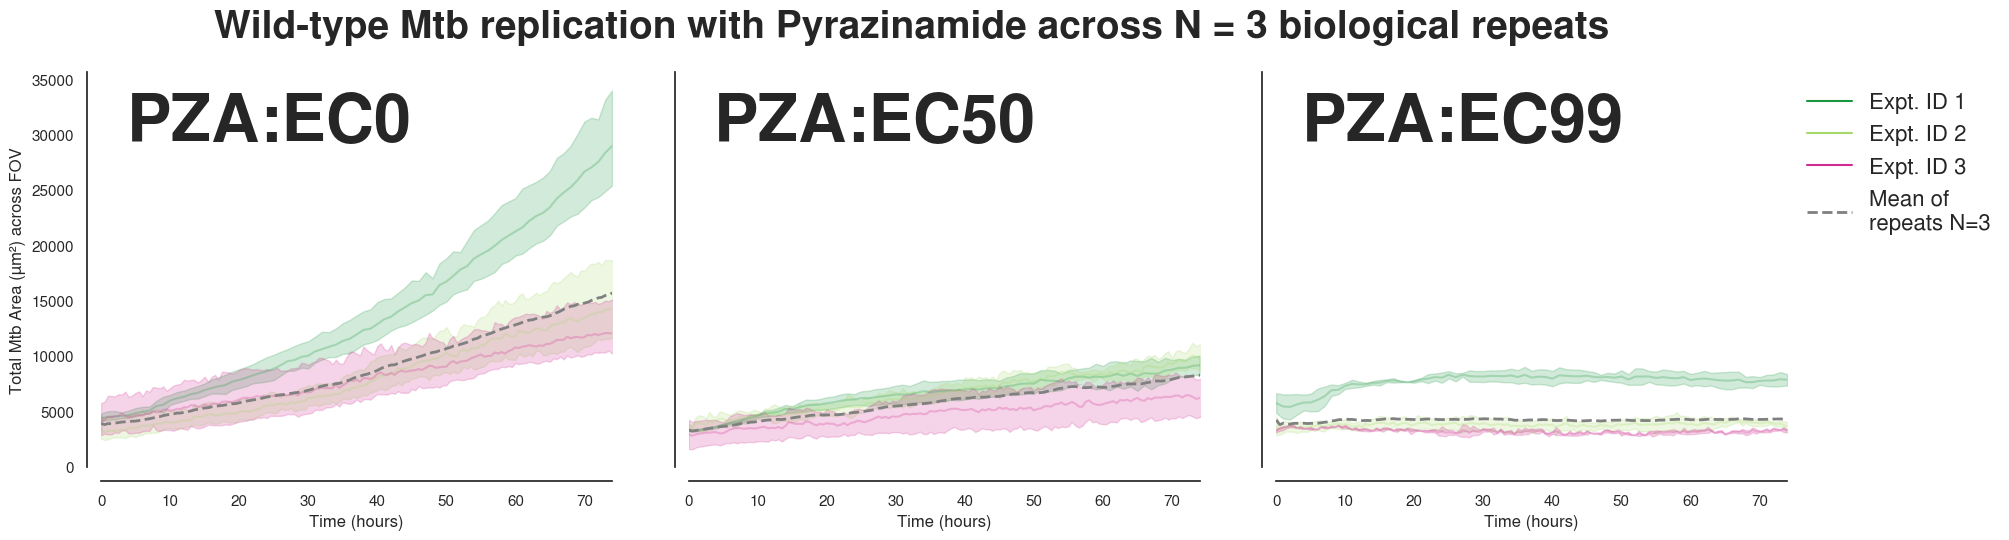

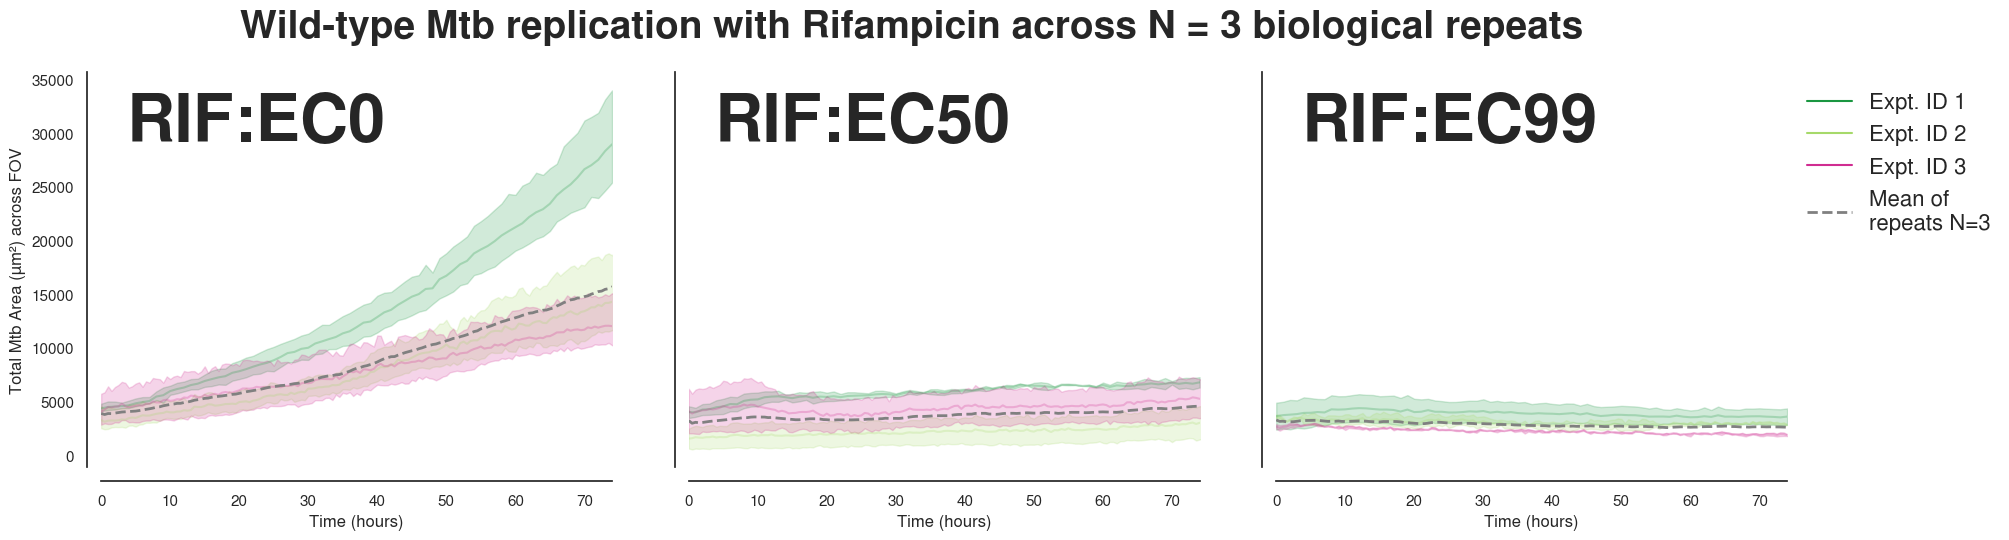

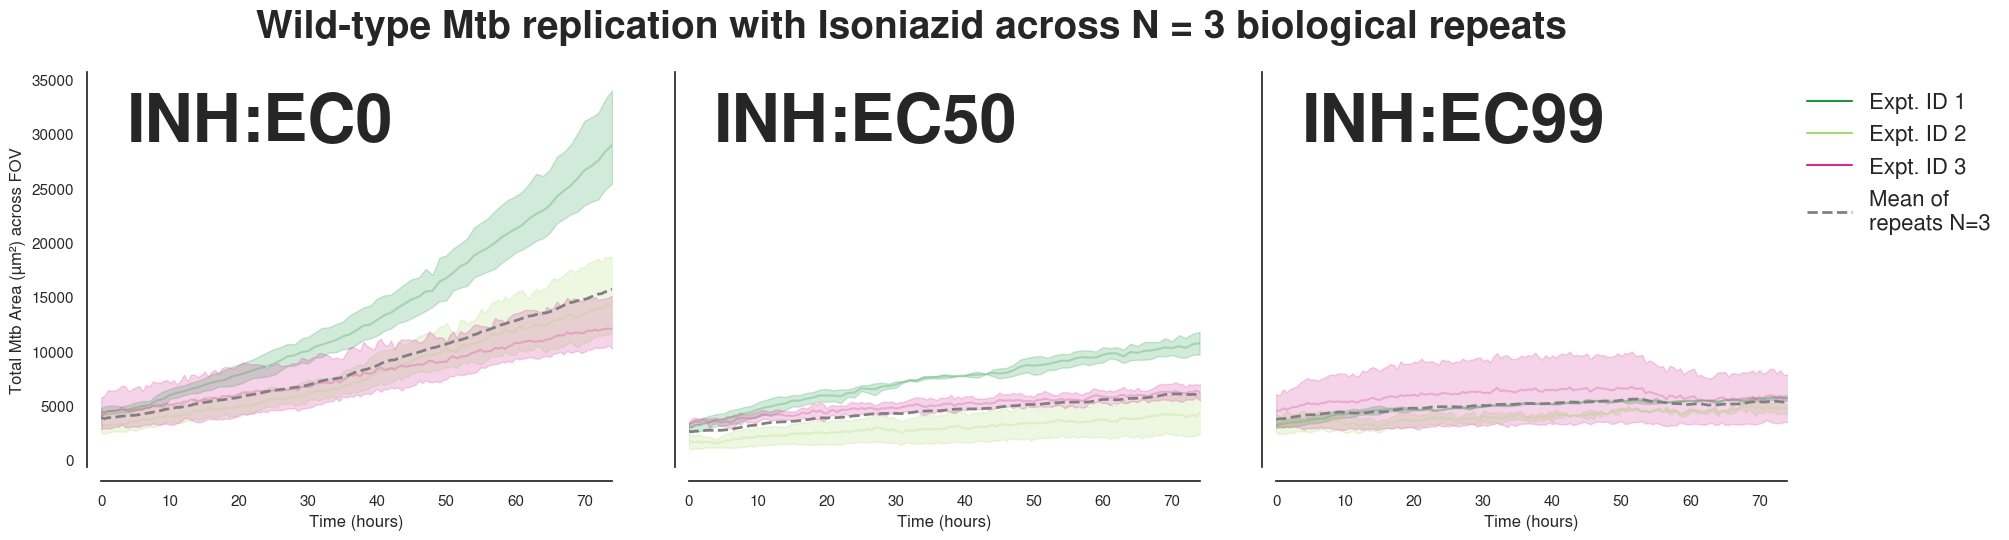

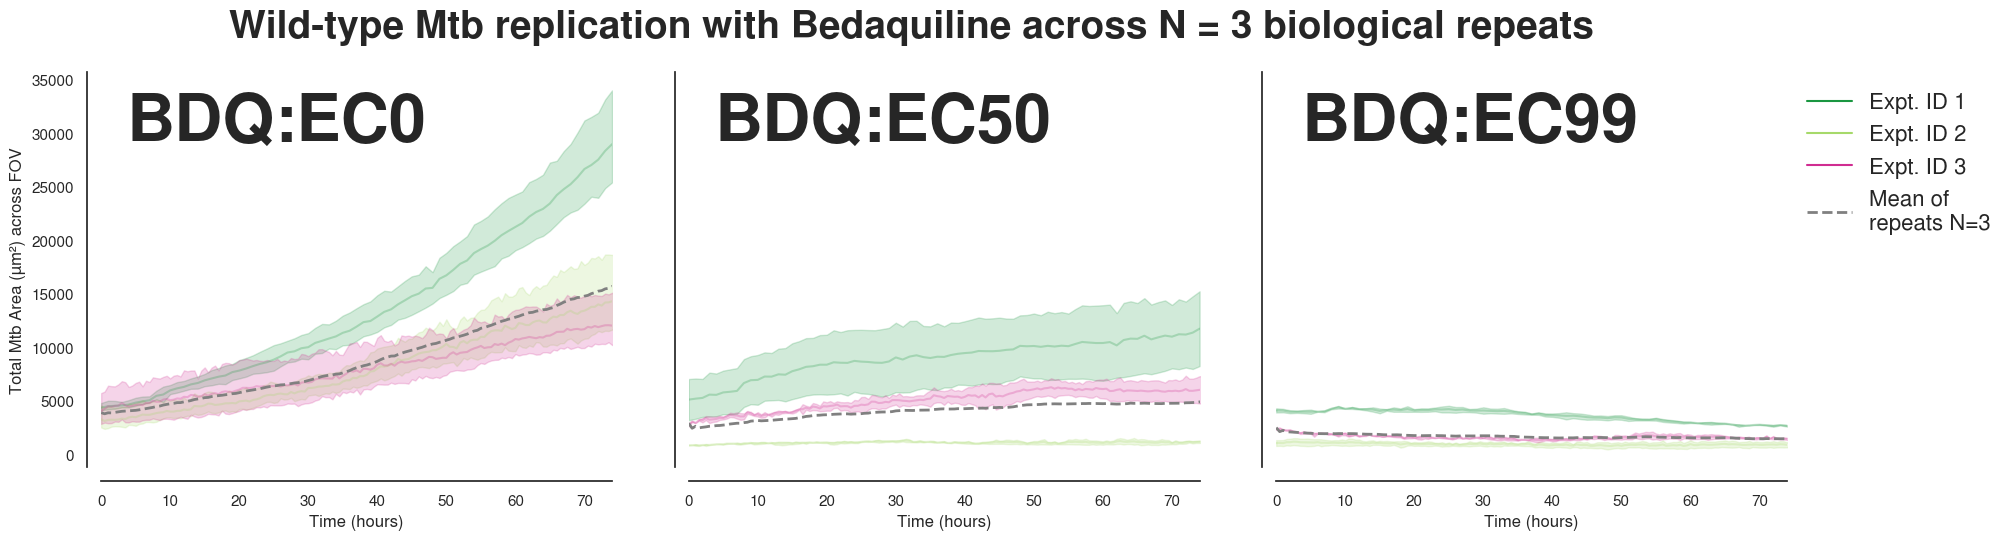

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os

# Sample data and colors (these should be defined elsewhere in your code)
# df = pd.read_csv('your_data.csv')  # Example of loading data
colors = [colours.expanded_piyg[0], colours.expanded_piyg[1], colours.expanded_piyg[5]]  # RD1 and WT colors

# Define line styles (if needed, currently not used)
line_styles = ['-', ':', '--', '-.']

compounds = ['PZA', 'RIF', 'INH', 'BDQ']

compounds_name_dict = {
    'PZA': 'Pyrazinamide',
    'RIF': 'Rifampicin',
    'INH': 'Isoniazid',
    'BDQ': 'Bedaquiline'
}


for compound in compounds:
    subset_df = df[((df['Compound'] == compound) | (df['Compound'] == 'CTRL')) & (df['Strain'] == 'WT')]
    
    # Plot all underlying data with low alpha
    g = sns.relplot(
        data=subset_df,
        y='Total Mtb Area (µm)',
        x='Time (hours)',
        kind='line',
        hue='Expt. ID',
        col='ConcentrationEC',
        palette=colors,
        alpha=0.25,
        height=5,
        aspect=1.2,
        legend=False  # Disable the automatic legend
    )
    
    # Calculate the mean values for numeric columns only
    mean_df = subset_df.groupby(['Time (hours)', 'ConcentrationEC']).mean(numeric_only=True).reset_index()
    
    # Apply rolling mean with a window size equivalent to 4 observations
    rolling_mean_dfs = []
    for name, group in mean_df.groupby('ConcentrationEC'):
        group['Rolling_Mean'] = group['Total Mtb Area (µm)'].rolling(window=4, min_periods=1).mean()
        rolling_mean_dfs.append(group)
    
    rolling_mean_df = pd.concat(rolling_mean_dfs)
    
    # Overlay the rolling mean data with higher alpha
    for ax, (name, group) in zip(g.axes.flat, rolling_mean_df.groupby('ConcentrationEC')):
        sns.lineplot(
            data=group,
            x='Time (hours)',
            y='Rolling_Mean',
            ax=ax,
            color= 'gray',#colours.expanded_piyg[0],  # Set the correct color for the mean line
            alpha=1, 
            linewidth=2,
            linestyle='--',
            legend=False  # Disable the legend for the lineplot
        )
        # Add new subtitles within the plot area
        ax.text(0.05, 0.95, f'{compound}:{name}', transform=ax.transAxes, ha='left', va='top', fontweight='bold', fontsize=48,)# style='italic')

    # Remove facet titles
    for ax in g.axes.flat:
        ax.set_title('')

    # Create custom legend entries
    expt_ids_text = ['Expt. ID 1', 'Expt. ID 2', 'Expt. ID 3']  # subset_df['Expt. ID'].unique()
    
    custom_lines = [mlines.Line2D([], [], color=color, linestyle='-', label=expt_id) for expt_id, color in zip(expt_ids_text, colors)]
    custom_lines.append(mlines.Line2D([], [], color='gray',
                                      # colours.expanded_piyg[0],
                                      linestyle='--', linewidth=2, label='Mean of \nrepeats N=3'))
    
    # Position the custom legend outside the plot area
    g.add_legend()
    plt.legend(handles=custom_lines, loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=16)  # Increase font size

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Mtb Area (µm²) across FOV')
    
    # Adjust spacing and remove original subtitles
    g.fig.subplots_adjust(hspace=0.2, wspace=0.15)  # Decrease the space between plots to half of previous adjustment
    g.set(xlim=(0, 74))
    
    # Customize the plot
    sns.despine(offset=10)
    plt.suptitle(f'Wild-type Mtb replication with {compounds_name_dict[compound]} across N = 3 biological repeats', y=1.05, weight='bold', fontsize=28, )#fontstyle='italic')  # Underline the title
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_WT_{compound}_CTRL_n3_overlaid.png'), bbox_inches='tight', dpi=314)
    
    plt.show()  # Display the plot

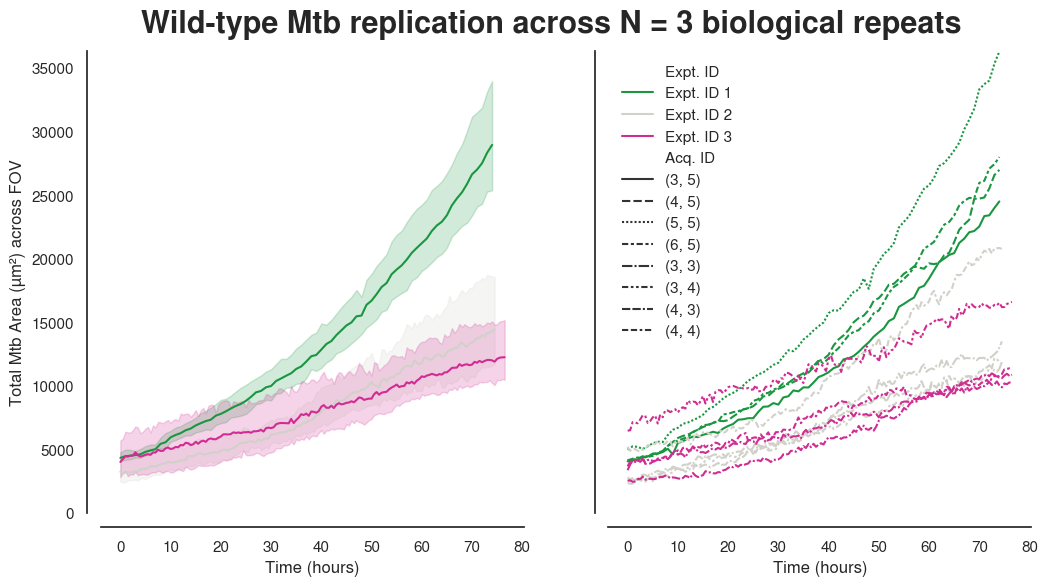

In [85]:

# Define line styles and colors
line_styles = ['-', ':', '--', '-.']
colors = [colours.expanded_piyg[0], colours.expanded_piyg[3], colours.expanded_piyg[5]]  # RD1 and WT colors

# Subset the dataframe
subset_df = df[(df['Strain'] == 'WT') & (df['Compound'] == 'CTRL')]

# Rename Expt. ID values
subset_df['Expt. ID'] = subset_df['Expt. ID'].replace({'PS0000': 'Expt. ID 1', 'ND0002': 'Expt. ID 2', 'ND0003': 'Expt. ID 3'})

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot without style
sns.lineplot(
    data=subset_df,
    y='Total Mtb Area (µm)',
    x='Time (hours)',
    hue='Expt. ID',
    palette=colors,
    ax=axes[0]
)
axes[0].set_ylim(0, subset_df['Total Mtb Area (µm)'].max())
axes[0].set_xlabel('Time (hours)')
axes[0].set_ylabel('Total Mtb Area (µm²) across FOV')
axes[0].legend_.remove()  # Remove legend from axes[0]

# Second plot with style
sns.lineplot(
    data=subset_df,
    y='Total Mtb Area (µm)',
    x='Time (hours)',
    hue='Expt. ID',
    style='Acq. ID',
    palette=colors,
    ax=axes[1]
)
axes[1].set_ylim(0, subset_df['Total Mtb Area (µm)'].max())
axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel('')  # Remove y-axis label
axes[1].yaxis.set_ticks([])  # Remove y-axis ticks

# Customize the legend on axes[1]
legend = axes[1].legend(frameon=False)  # Remove the frame from the legend

sns.despine(offset=10)

plt.suptitle('Wild-type Mtb replication across N = 3 biological repeats', y=0.95, weight='bold', fontsize=22)

# Save the combined figure
plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_WT_CTRL_n3_positions.png'), bbox_inches='tight', dpi=314)
plt.show()

### RD1 and WT

In [246]:
df[(df['Strain'] == 'WT') 
            & (df['Compound'] == 'CTRL')]['Acq. ID'].unique()

array([(3, 5), (4, 5), (5, 5), (6, 5), (3, 3), (3, 4), (4, 3), (4, 4)],
      dtype=object)

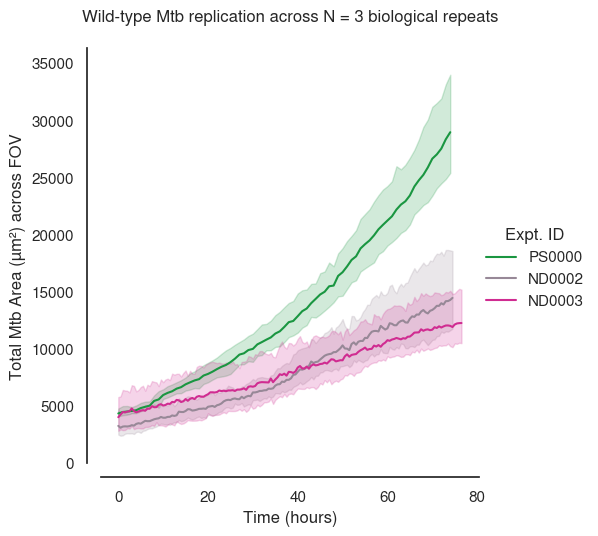

In [274]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
subset_df =  df[(df['Strain'] == 'WT') 
            & (df['Compound'] == 'CTRL')]
sns.relplot(
    data =subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Mtb Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    # style = 'Acq. ID',
    palette = colors
)

plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Total Mtb Area (µm²) across FOV')
plt.title('Wild-type Mtb replication across N = 3 biological repeats\n')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_mtb_growth_WT.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


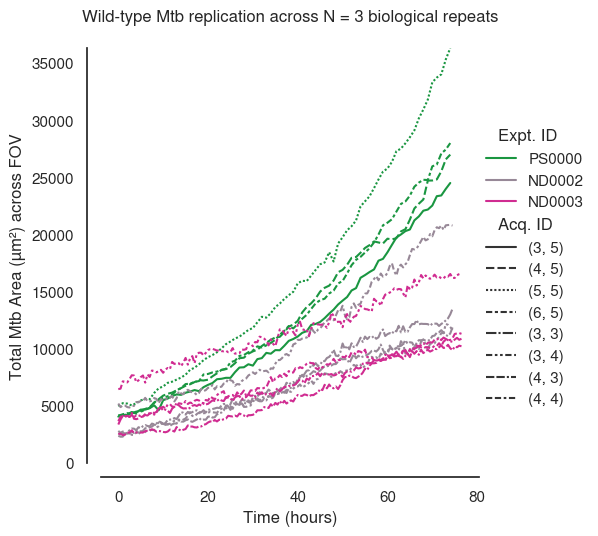

In [249]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Strain'] == 'WT') 
             & (df['Compound'] == 'CTRL')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Mtb Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    style = 'Acq. ID',
    palette = colors
)
plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())
sns.despine(offset=10)
plt.ylabel('')
plt.xlabel('Time (hours)')
plt.ylabel('Total Mtb Area (µm²) across FOV')
plt.title('Wild-type Mtb replication across N = 3 biological repeats\n')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_mtb_growth_WT_positions.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


## RD1 - needs fixing for ND3.5.3

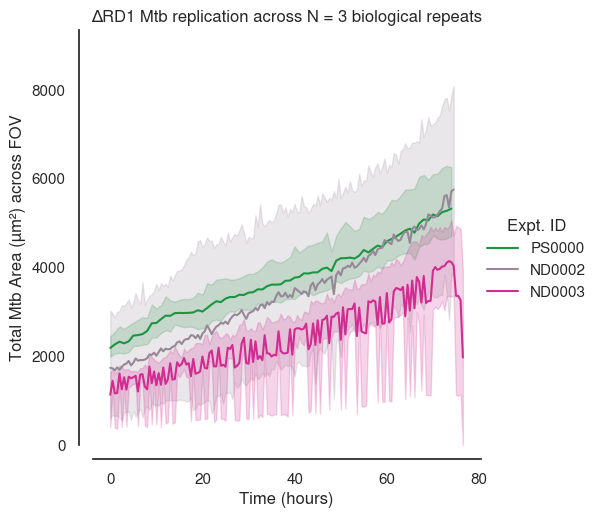

In [275]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Strain'] == 'RD1') 
             & (df['Compound'] == 'CTRL')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Mtb Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID',
    palette = colors
)

plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())
plt.ylabel('Total Mtb Area (µm²) across FOV')
sns.despine(offset=10)
plt.xlabel('Time (hours)')
plt.title('ΔRD1 Mtb replication across N = 3 biological repeats')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_mtb_growth_RD1.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


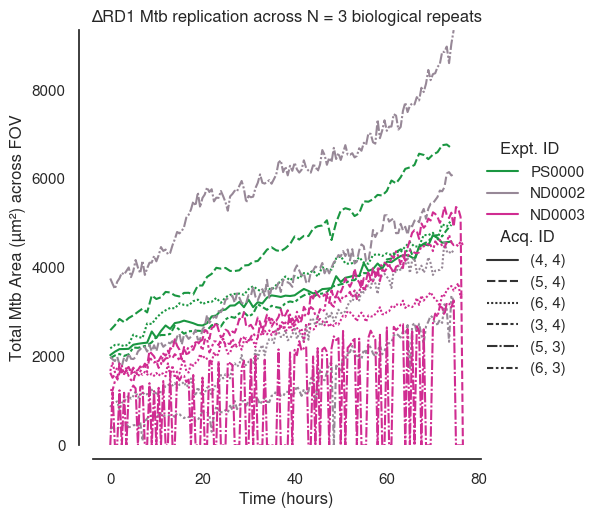

In [287]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Strain'] == 'RD1') 
             & (df['Compound'] == 'CTRL')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Mtb Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    style = 'Acq. ID',
    palette = colors
)

sns.despine(offset=10)
plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())
plt.ylabel('Total Mtb Area (µm²) across FOV')
plt.xlabel('Time (hours)')
plt.title('ΔRD1 Mtb replication across N = 3 biological repeats')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_mtb_growth_RD1_positions.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


## WT and RD1

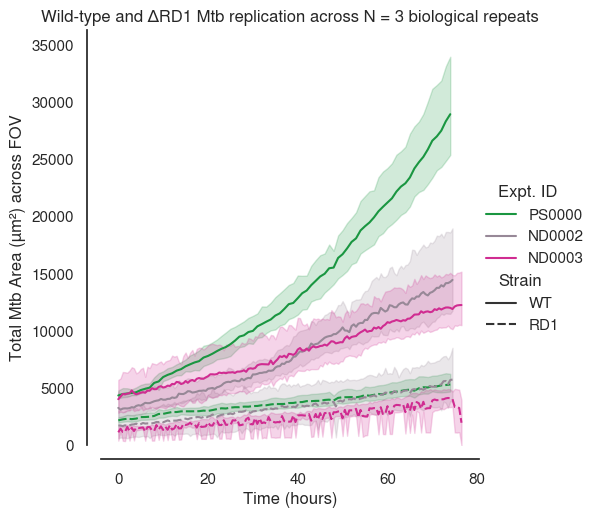

In [288]:
# Define line styles and colors
line_styles = ['-', ':', '--', '-.']  # You can add more if needed
colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors

subset_df = df[(df['Compound'] == 'CTRL') & (df['Strain'] != 'UNI')]

sns.relplot(
    data = subset_df,#[df['Expt. ID']=='ND0002'], 
    y = 'Total Mtb Area (µm)',
    x = 'Time (hours)',
    kind = 'line',
    hue = 'Expt. ID', 
    # style = 'Acq. ID',
    style='Strain',
    palette = colors
)

sns.despine(offset=10)
plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())
plt.ylabel('Total Mtb Area (µm²) across FOV')
plt.xlabel('Time (hours)')
plt.title('Wild-type and ΔRD1 Mtb replication across N = 3 biological repeats')# over the whole field of view (including outlier values)')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
plt.savefig(os.path.join(output_dir, 'whole_fov_mtb_growth_WT_RD1.png'), bbox_inches='tight', dpi=314)
plt.show()  # Display the plot


## Comparing Atbs

#### Add repeat number to assay layout

### mapping colours to previous

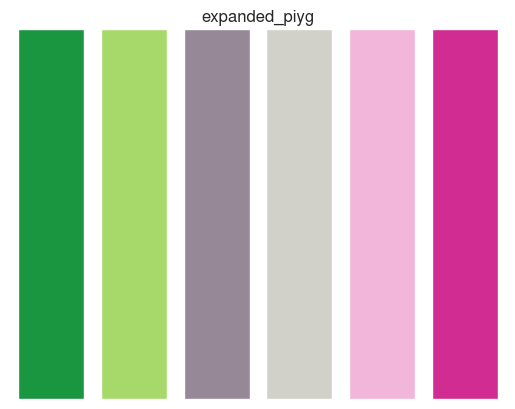

[(0, '#1a9641'),
 (1, '#a6d96a'),
 (2, '#978897'),
 (3, '#d1d1ca'),
 (4, '#f1b6da'),
 (5, '#d02c91')]

In [279]:
### mapping colours to be teh same as last time
# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg')
[(n, i) for n, i in enumerate(colours.expanded_piyg)]

In [280]:
colour_map_dict = {'RD1':colours.expanded_piyg[0], 
                   'WT': colours.expanded_piyg[1], 
                   'PZA': colours.expanded_piyg[2], 
                   'RIF': colours.expanded_piyg[3], 
                   'INH': colours.expanded_piyg[4], 
                   'BDQ': colours.expanded_piyg[5], 
                   'UNI': '#000000'}

### Plot different atb conditions per repeat

In [300]:
subset_df

Frame  Acq. ID Expt. ID  Time (hours)  Row  Column Strain Compound  \
6150       0  (5, 11)   ND0002           0.0    5      11    RD1      BDQ   
6151       1  (5, 11)   ND0002           0.5    5      11    RD1      BDQ   
6152       2  (5, 11)   ND0002           1.0    5      11    RD1      BDQ   
6153       3  (5, 11)   ND0002           1.5    5      11    RD1      BDQ   
6154       4  (5, 11)   ND0002           2.0    5      11    RD1      BDQ   
...      ...      ...      ...           ...  ...     ...    ...      ...   
13793    149  (6, 12)   ND0003          74.5    6      12    RD1      BDQ   
13794    150  (6, 12)   ND0003          75.0    6      12    RD1      BDQ   
13795    151  (6, 12)   ND0003          75.5    6      12    RD1      BDQ   
13796    152  (6, 12)   ND0003          76.0    6      12    RD1      BDQ   
13797    153  (6, 12)   ND0003          76.5    6      12    RD1      BDQ   

      Concentration ConcentrationEC  Replicate #  Total Mtb Area (µm)  
6150           0.02            EC50            1           707.932234  
6151           0.02            EC50            1           588.233871  
6152           0.02            EC50            1           686.500058  
6153           0.02            EC50            1           815.227200  
6154           0.02            EC50            1           783.514732  
...             ...             ...          ...                  ...  
13793           2.5            EC99            2           887.770308  
13794           2.5            EC99            2           856.951779  
13795           2.5            EC99            2           884.797962  
13796           2.5            EC99            2           843.766186  
13797           2.5            EC99            2           827.630596  

[1216 rows x 12 columns]

In [304]:
compound = 'PZA'

/tmp/ipykernel_718437/1273287920.py:5: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  g = sns.relplot(
/tmp/ipykernel_718437/1273287920.py:5: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  g = sns.relplot(
/tmp/ipykernel_718437/1273287920.py:5: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  g = sns.relplot(
/tmp/ipykernel_718437/1273287920.py:5: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  g = sns.relplot(


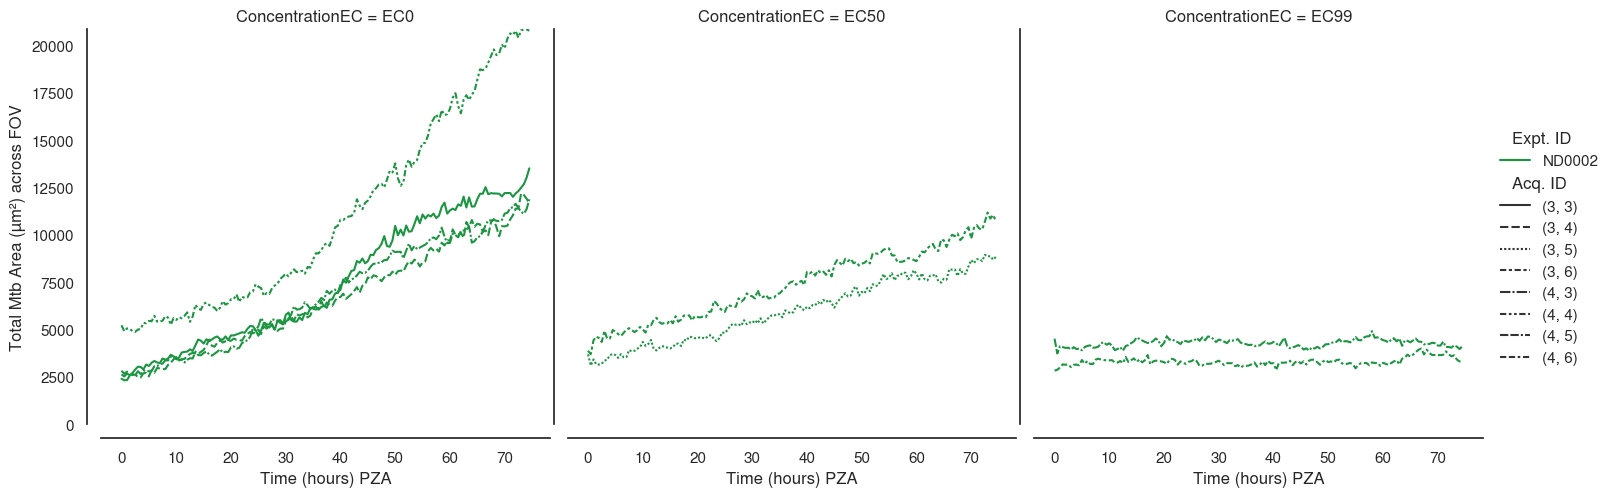

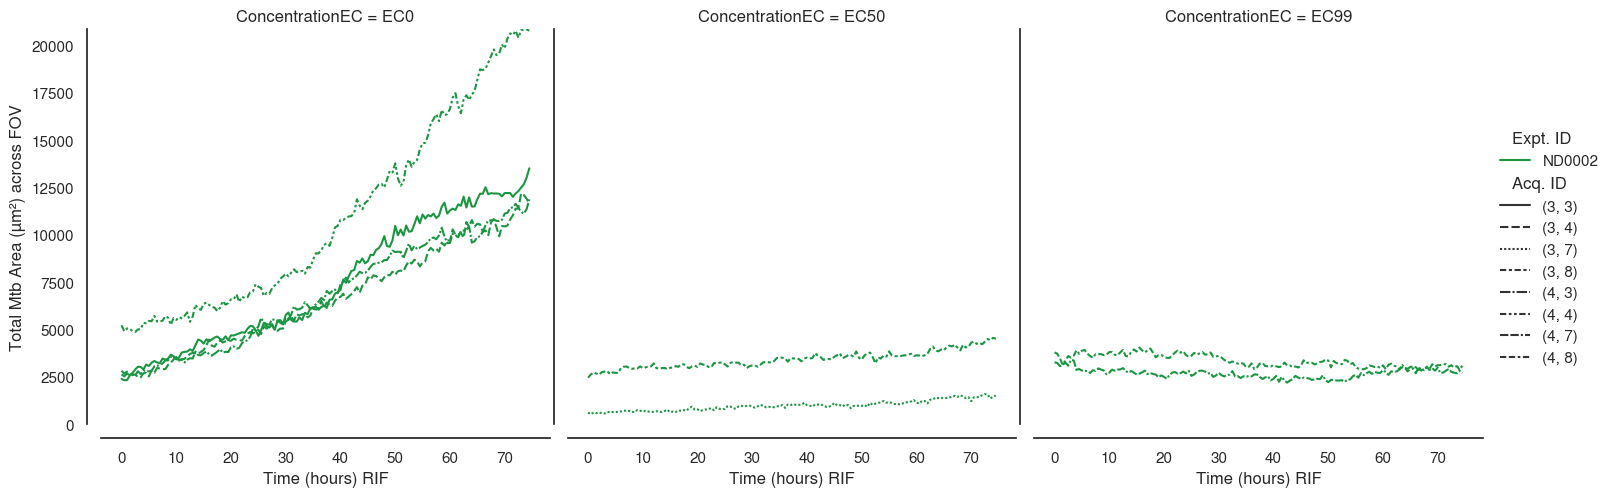

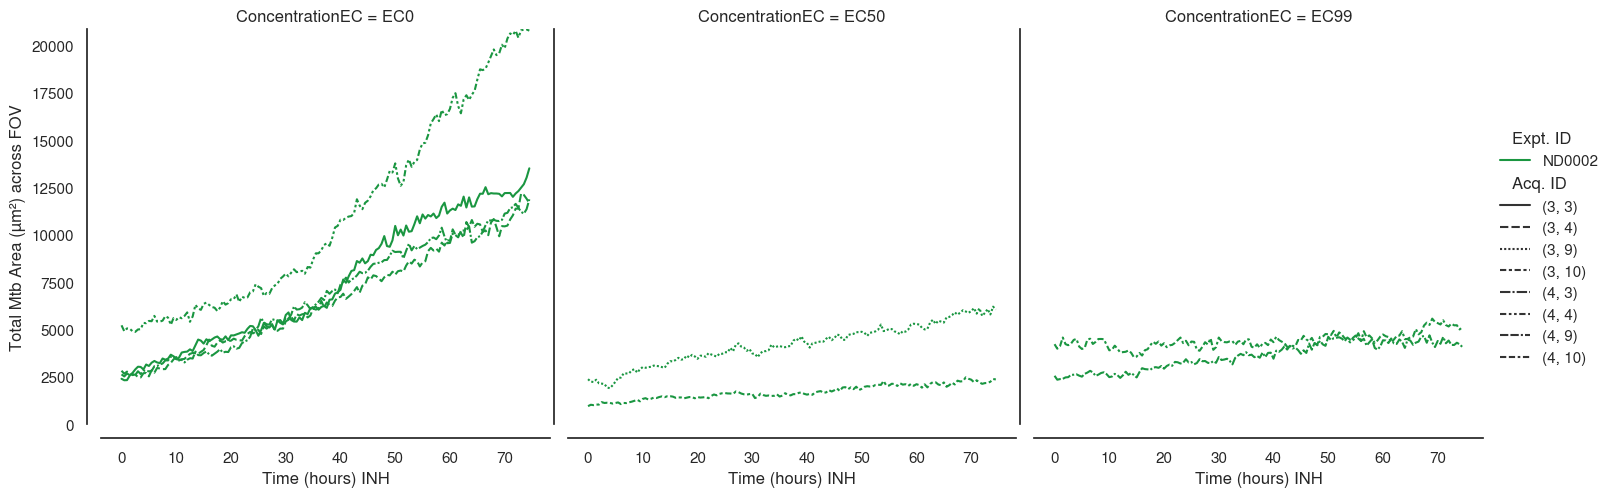

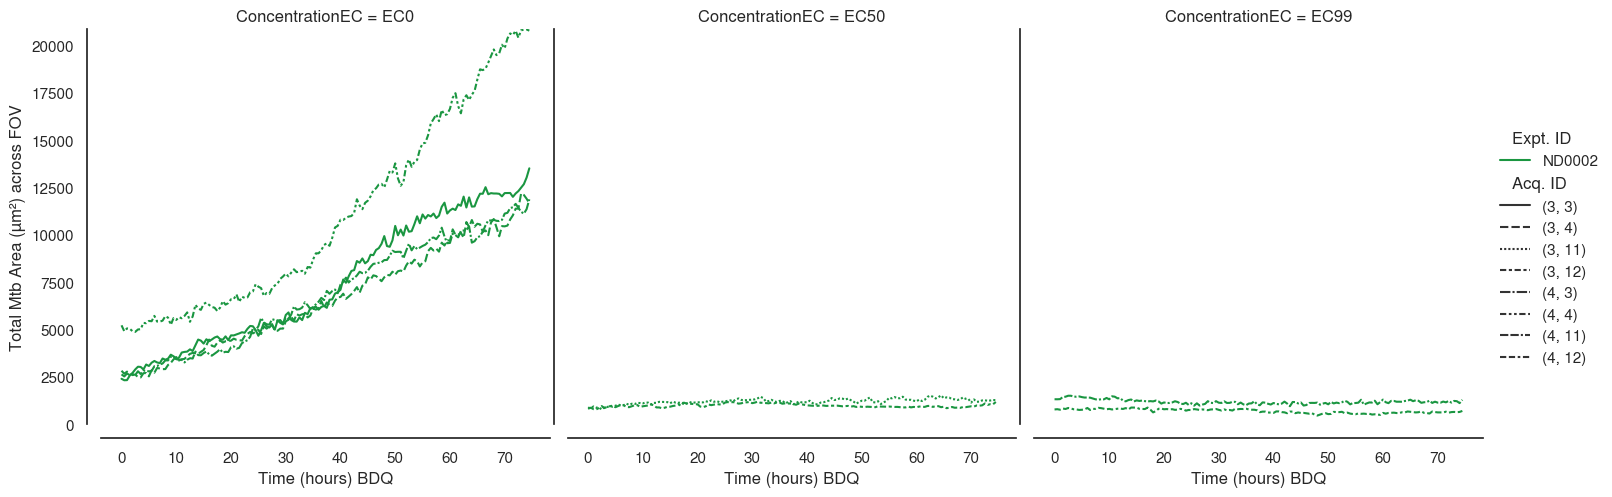

In [309]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']
for compound in compounds:
    subset_df = df[((df['Compound'] == compound) | (df['Compound'] == 'CTRL')) & (df['Strain'] == 'WT') & (df['Expt. ID'] == 'ND0002')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Mtb Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')
    
    # Set overall labels for the figure
    g.set_axis_labels(f'Time (hours) {compound}', 'Total Mtb Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())
    plt.savefig(f'temp_{compound}.png', bbox_inches='tight', dpi=314)


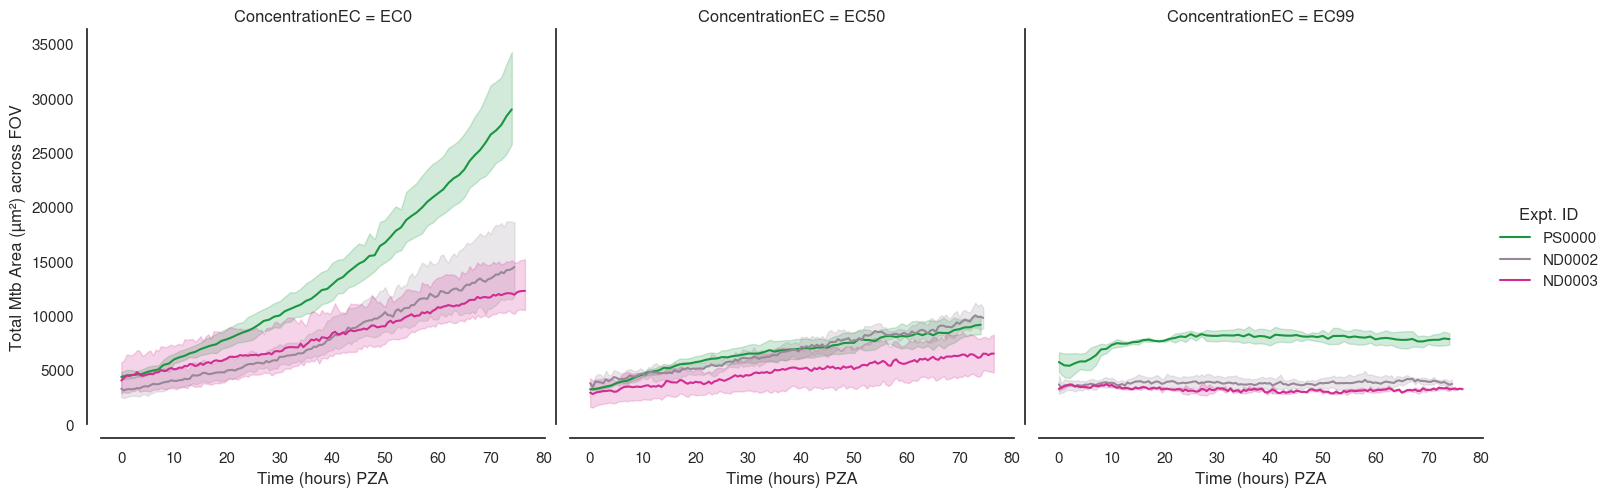

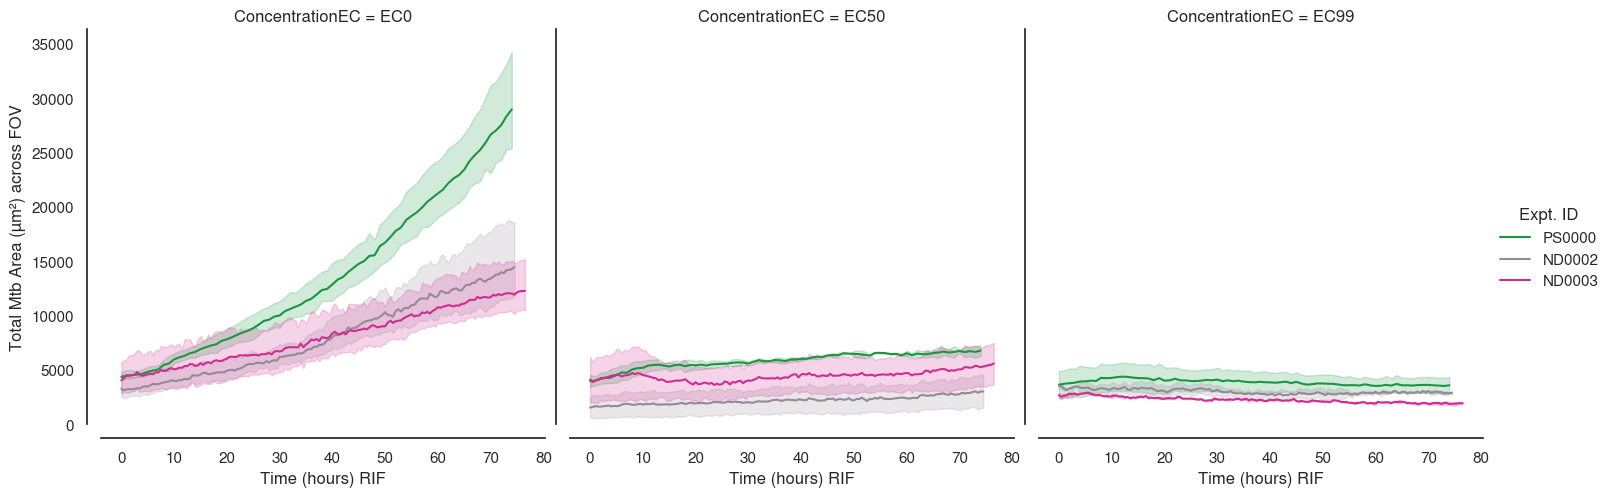

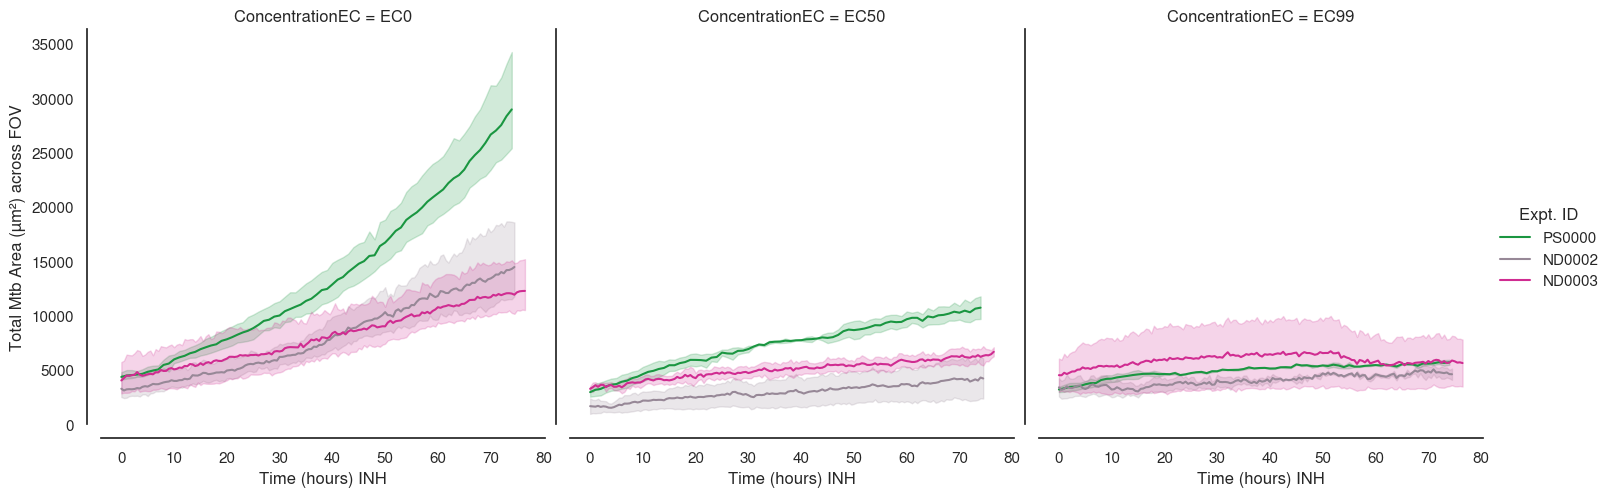

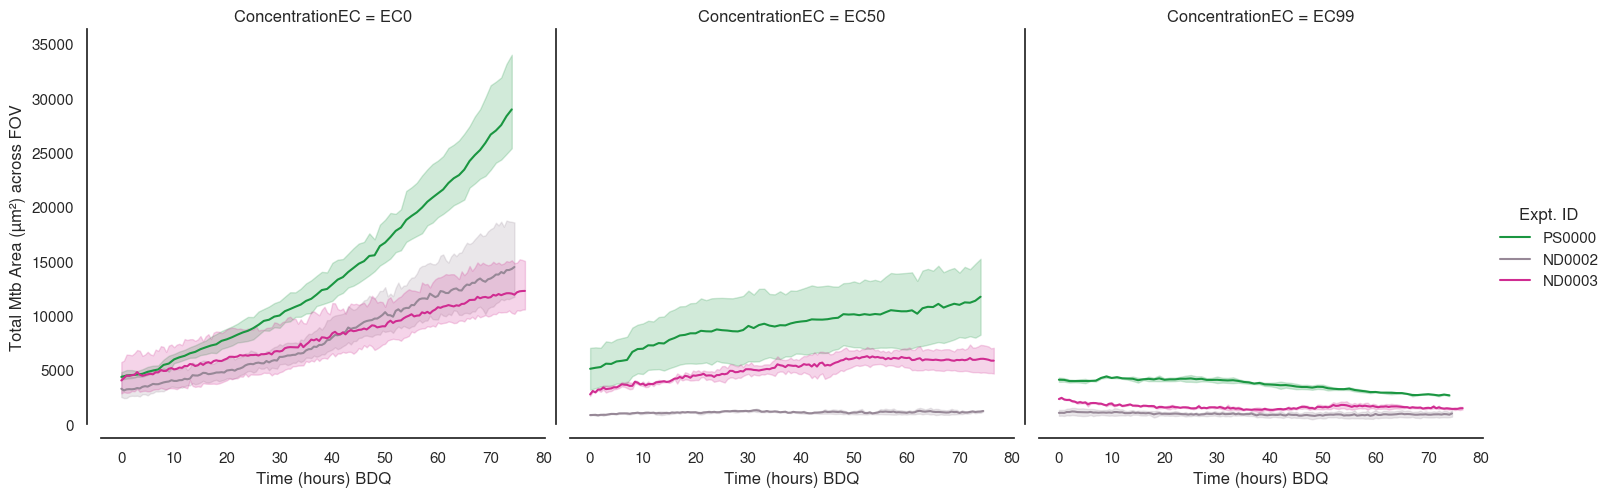

In [306]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']
for compound in compounds:
    subset_df = df[((df['Compound'] == compound) | (df['Compound'] == 'CTRL')) & (df['Strain'] == 'WT')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Mtb Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        # style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')
    
    # Set overall labels for the figure
    g.set_axis_labels(f'Time (hours) {compound}', 'Total Mtb Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())
    plt.savefig(f'temp_{compound}.png', bbox_inches='tight', dpi=314)


  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

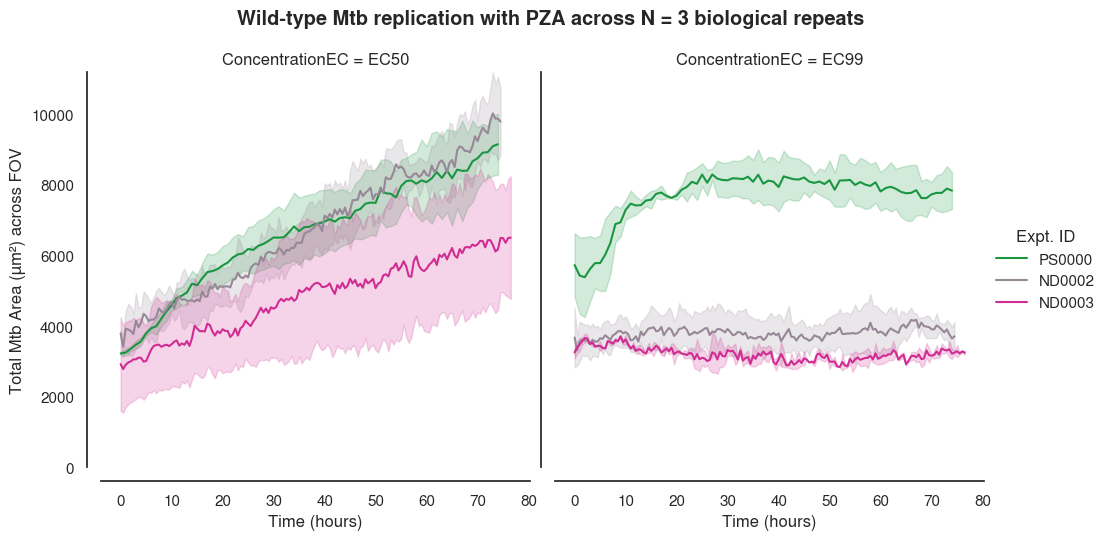

<Figure size 640x480 with 0 Axes>

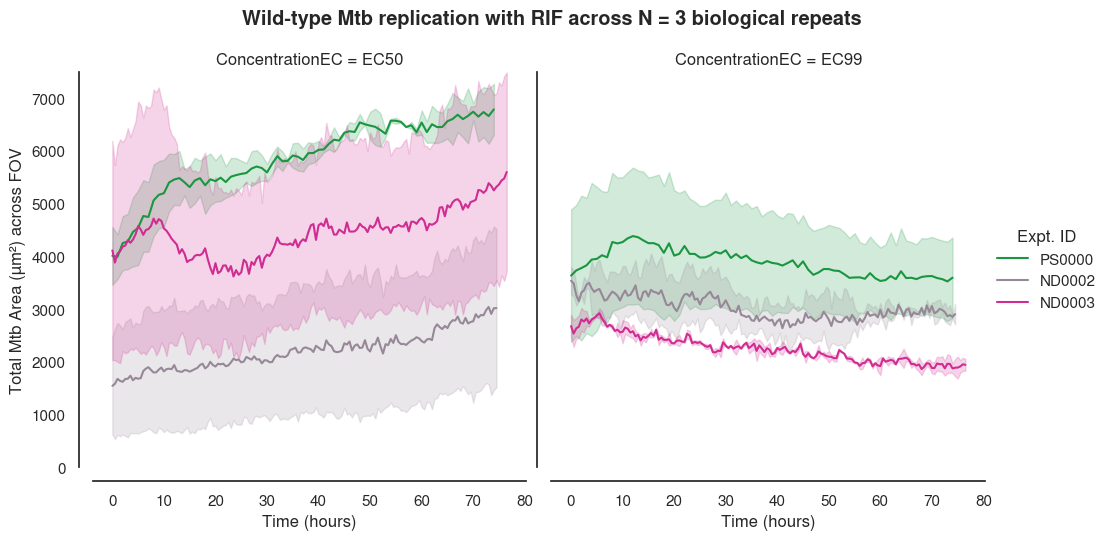

<Figure size 640x480 with 0 Axes>

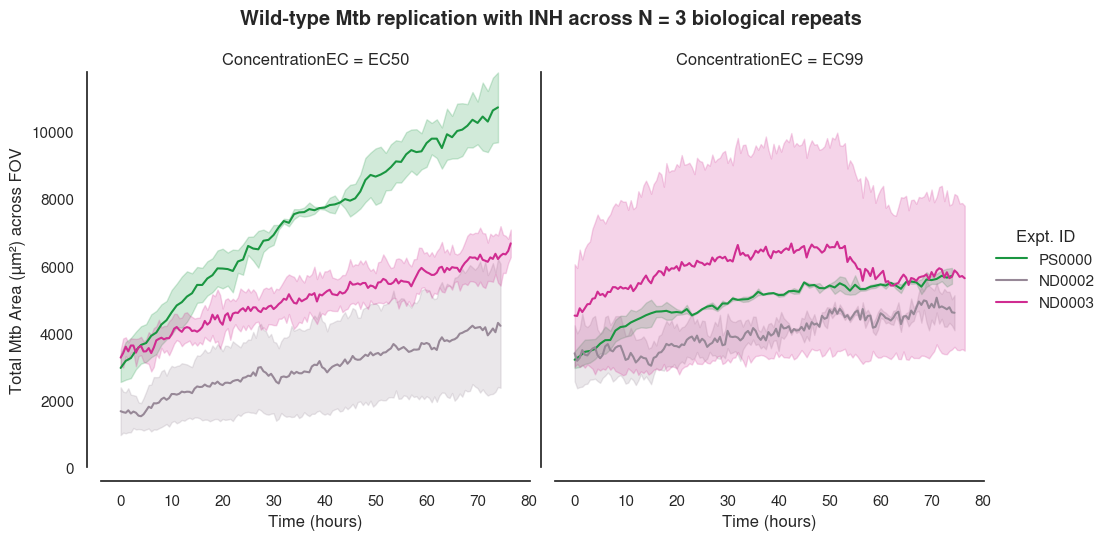

<Figure size 640x480 with 0 Axes>

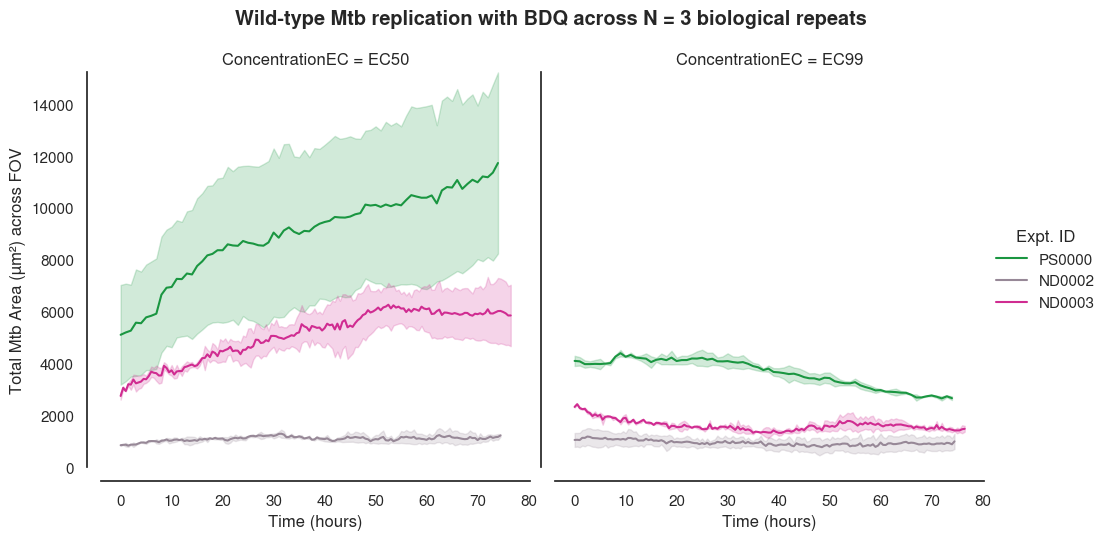

In [295]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'WT')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Mtb Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        # style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Mtb Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())

    plt.suptitle(f'Wild-type Mtb replication with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_WT_{compound}.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

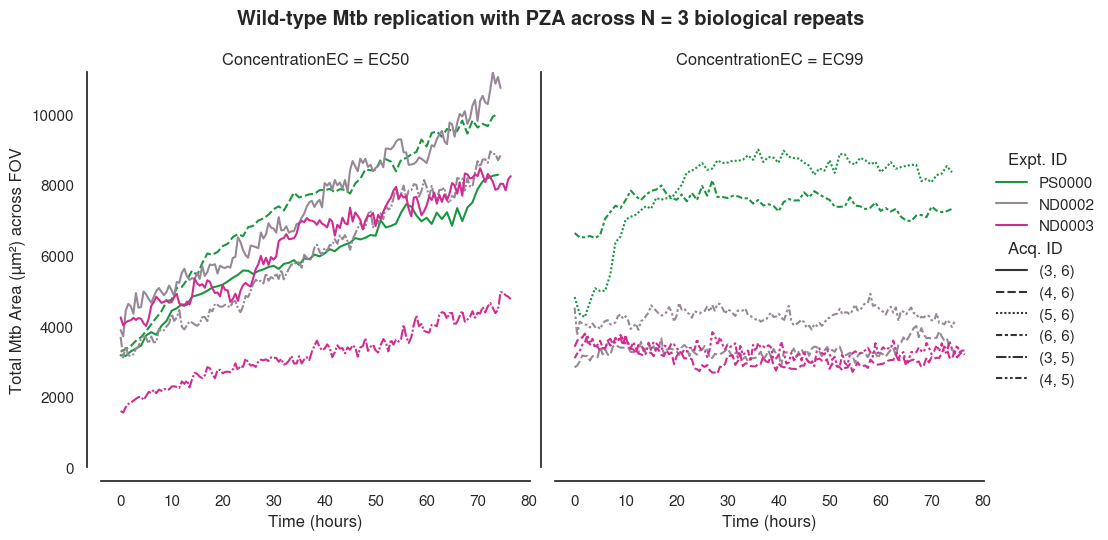

<Figure size 640x480 with 0 Axes>

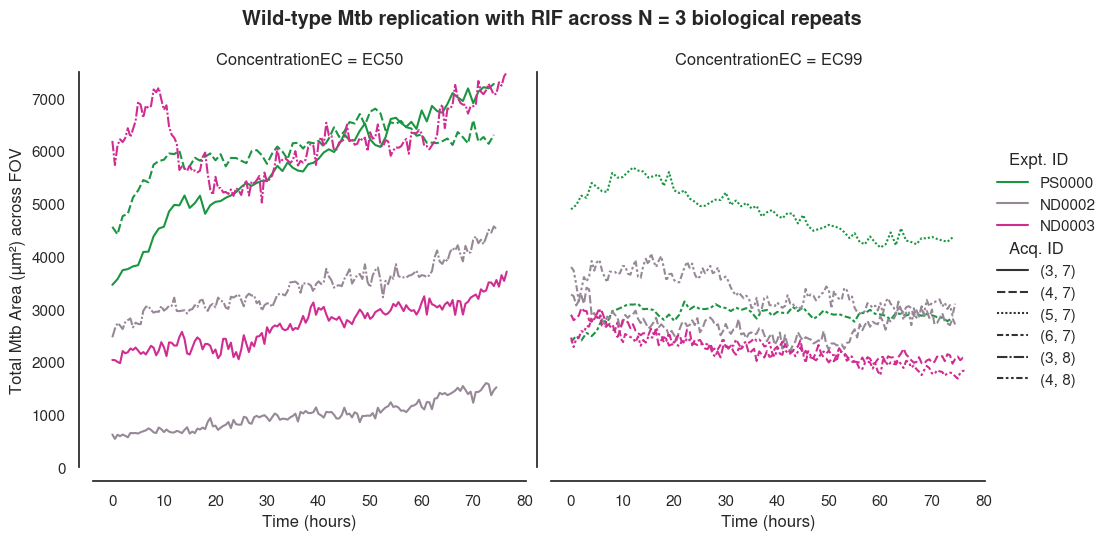

<Figure size 640x480 with 0 Axes>

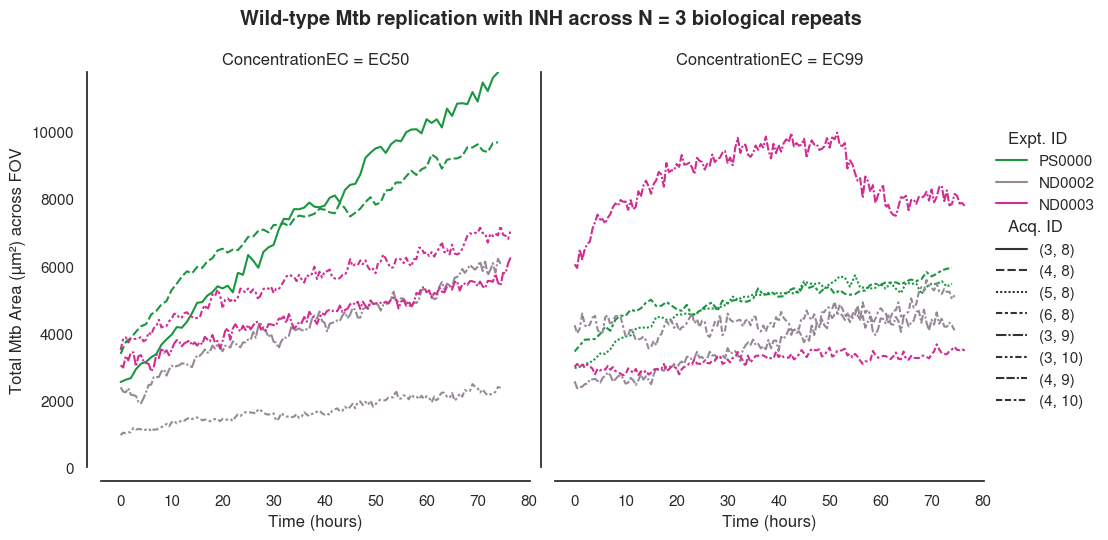

<Figure size 640x480 with 0 Axes>

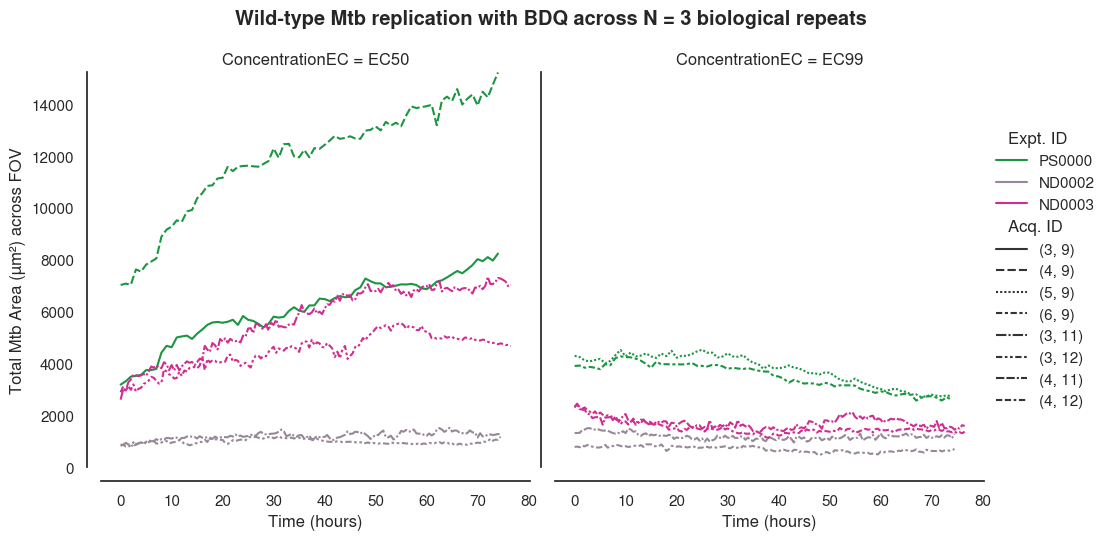

In [297]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'WT')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Mtb Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Mtb Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())

    plt.suptitle(f'Wild-type Mtb replication with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_WT_{compound}_positions.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


# RD1

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_718437/2216435841.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

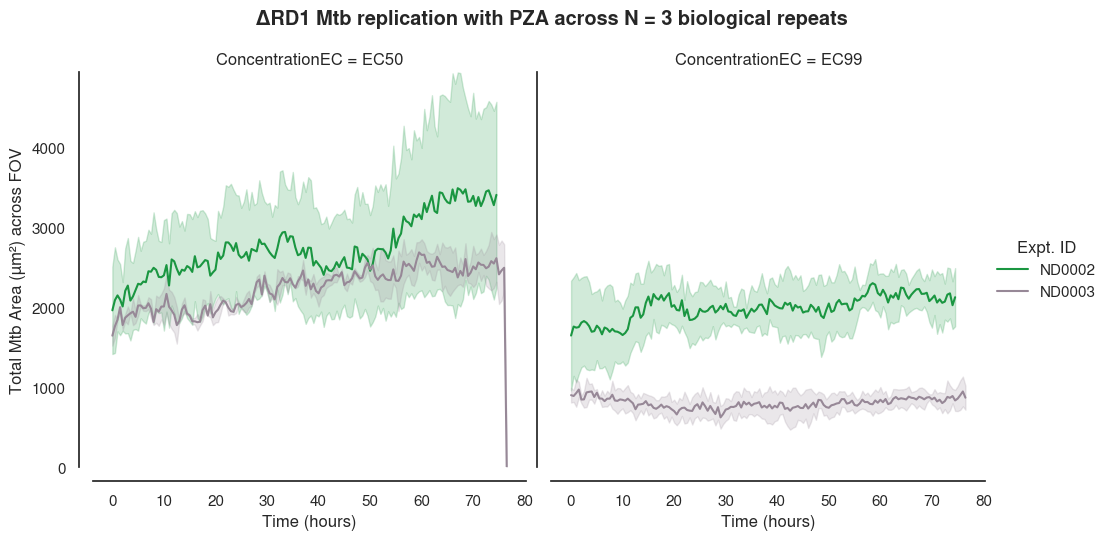

/tmp/ipykernel_718437/2216435841.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

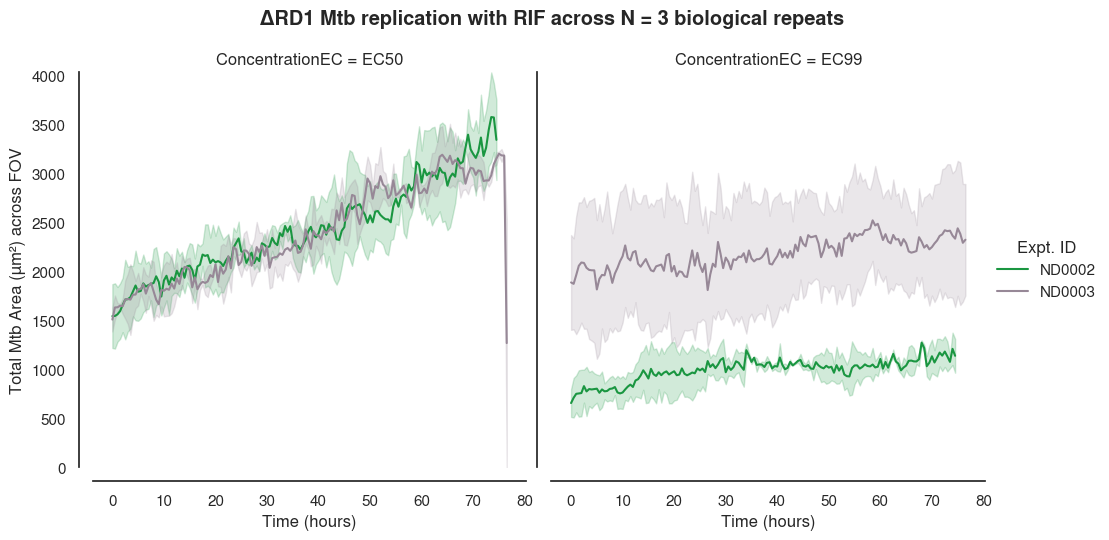

/tmp/ipykernel_718437/2216435841.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

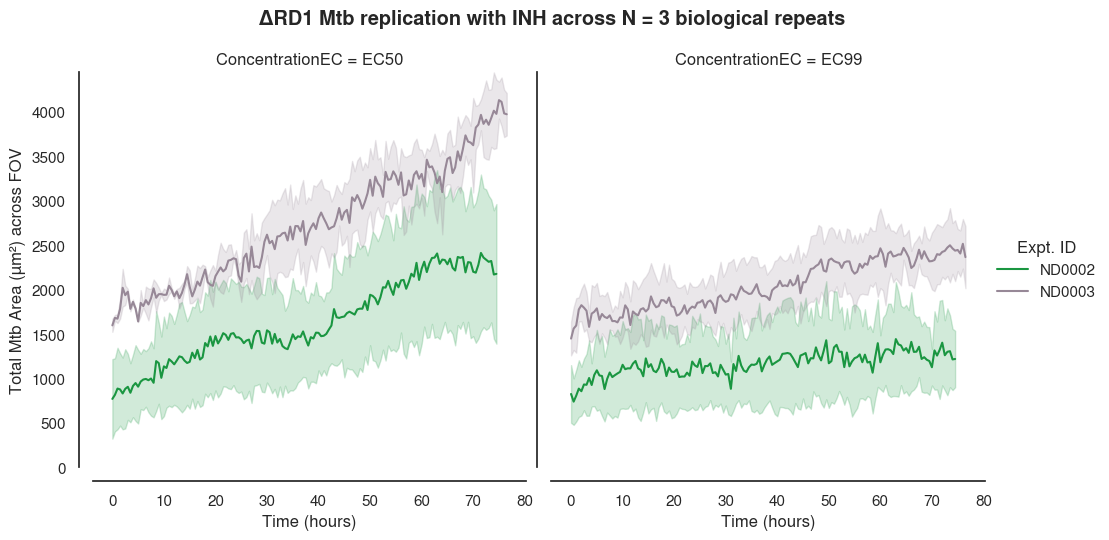

/tmp/ipykernel_718437/2216435841.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

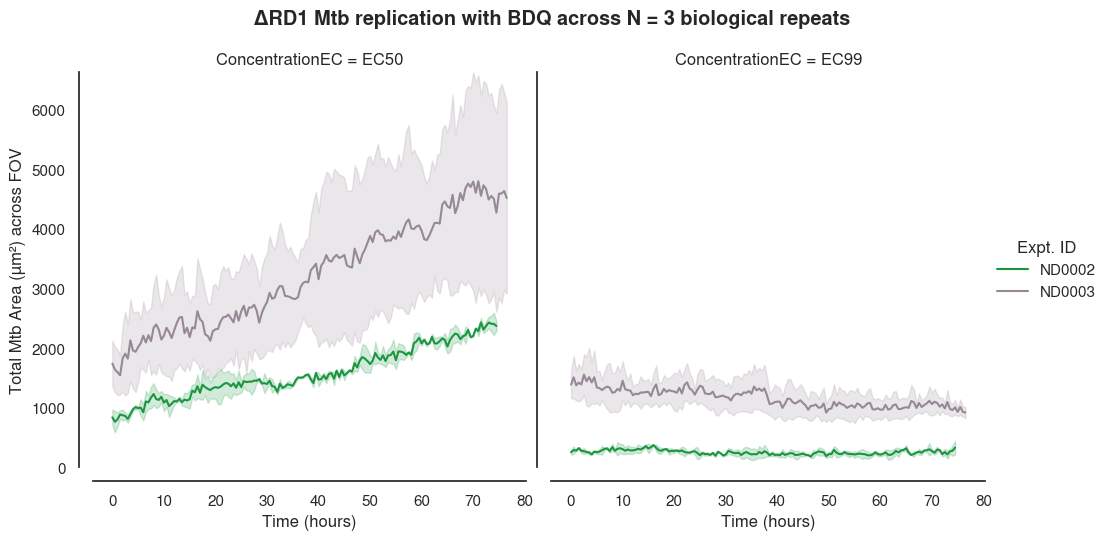

In [298]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'RD1')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Mtb Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        # style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Mtb Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())

    plt.suptitle(f'ΔRD1 Mtb replication with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_RD1_{compound}.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_718437/193192400.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

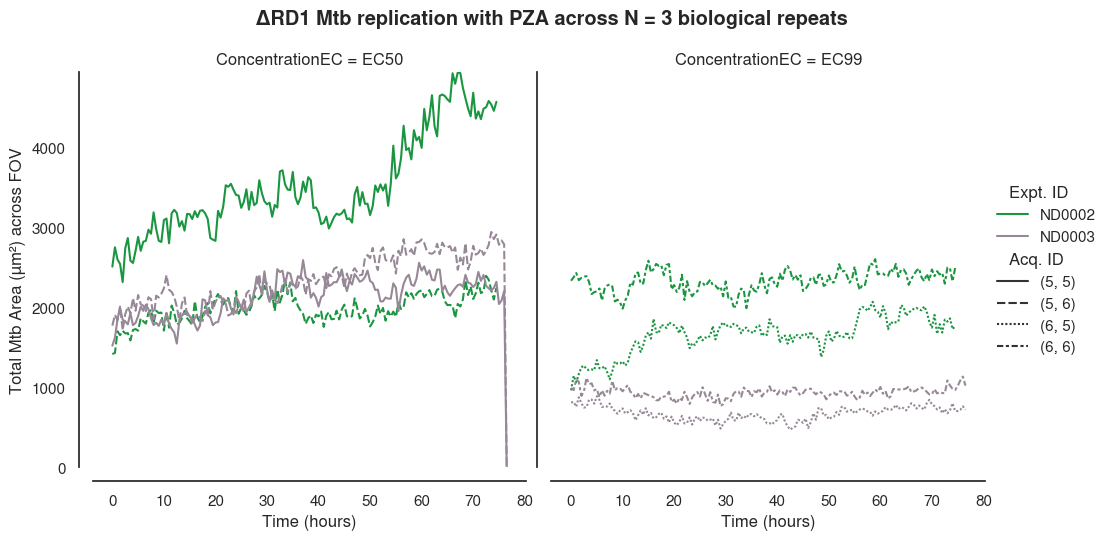

/tmp/ipykernel_718437/193192400.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

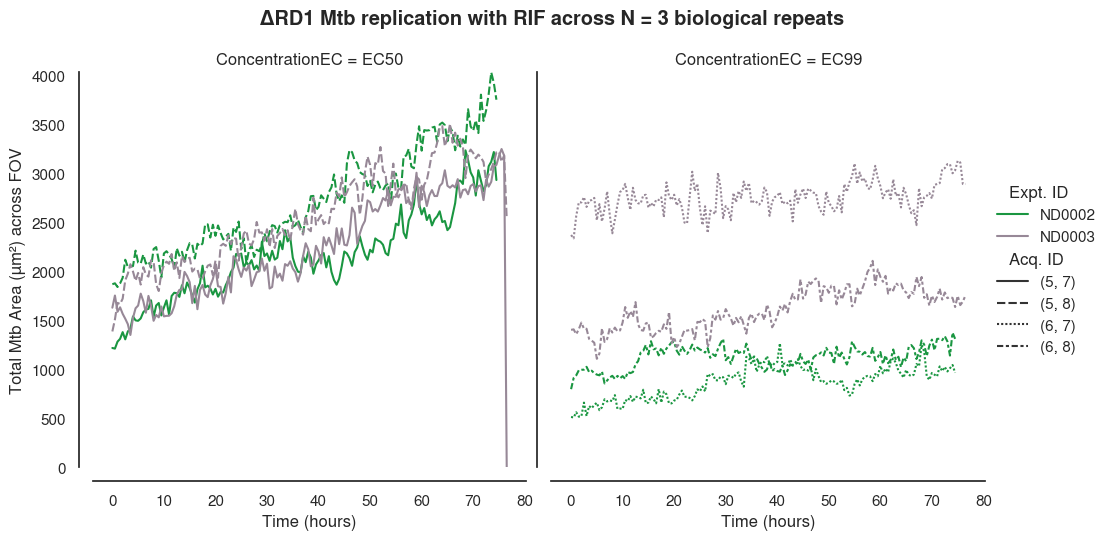

/tmp/ipykernel_718437/193192400.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

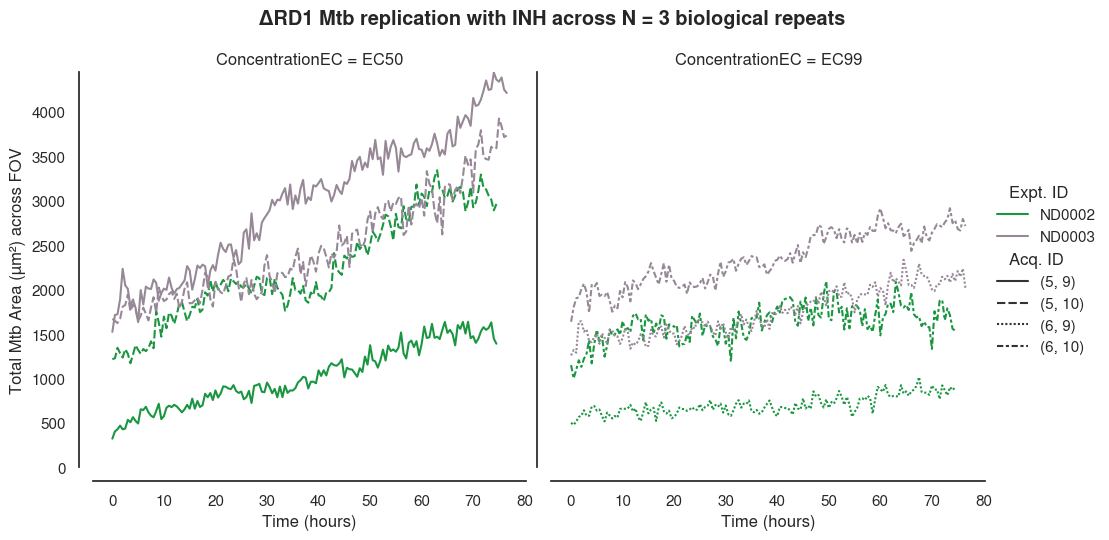

/tmp/ipykernel_718437/193192400.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  g = sns.relplot(


<Figure size 640x480 with 0 Axes>

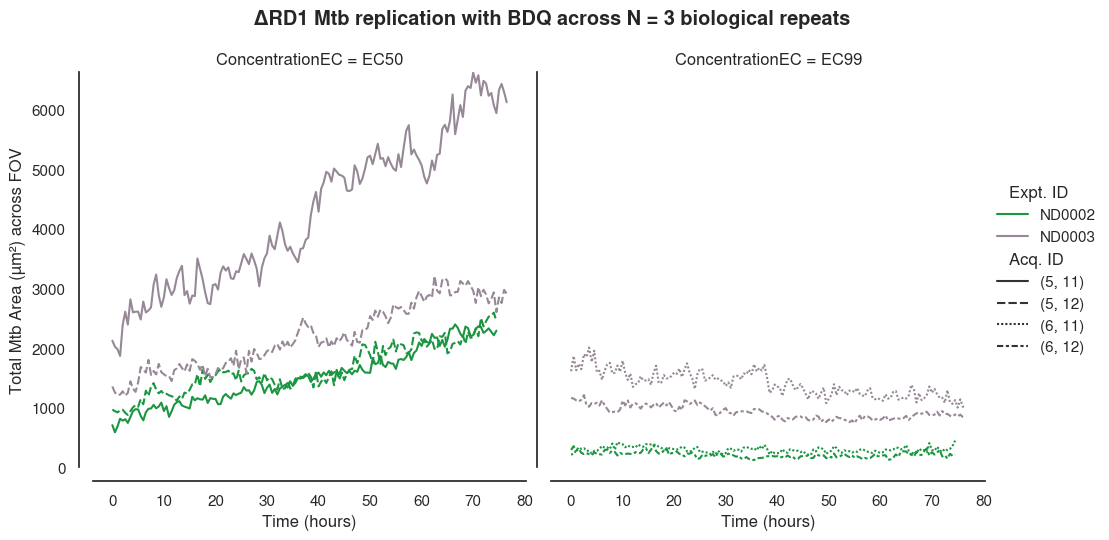

In [299]:
compounds = ['PZA', 'RIF', 'INH', 'BDQ']

for compound in tqdm(compounds):
    plt.clf()
    # Define line styles and colors
    line_styles = ['-', ':', '--', '-.']  # You can add more if needed
    colors = [colours.expanded_piyg[0], colours.expanded_piyg[2], colours.expanded_piyg[5]]  # RD1 and WT colors
    
    subset_df = df[(df['Compound'] == compound) & (df['Strain'] == 'RD1')]
    
    g = sns.relplot(
        data = subset_df,#[df['Expt. ID']=='ND0002'], 
        y = 'Total Mtb Area (µm)',
        x = 'Time (hours)',
        kind = 'line',
        hue = 'Expt. ID', 
        col = 'ConcentrationEC',
        style='Acq. ID',
        palette = colors
    )
    
    # Removing individual labels by accessing axes
    for ax in g.axes.flat:
        ax.set_xlabel('')  # Remove x label on each subplot
        ax.set_ylabel('')

    # Set overall labels for the figure
    g.set_axis_labels('Time (hours)', 'Total Mtb Area (µm²) across FOV')
    
    sns.despine(offset=10)
    plt.ylim(0, subset_df['Total Mtb Area (µm)'].max())

    plt.suptitle(f'ΔRD1 Mtb replication with {compound} across N = 3 biological repeats', y=1.05, weight='bold')# over the whole field of view (including outlier values)')
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title = 'Mtb strain : experiment ID')  # Add a legend
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_RD1_{compound}_positions.png'), bbox_inches='tight', dpi=314)
    plt.show()  # Display the plot


# Old approach

/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3429643671.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


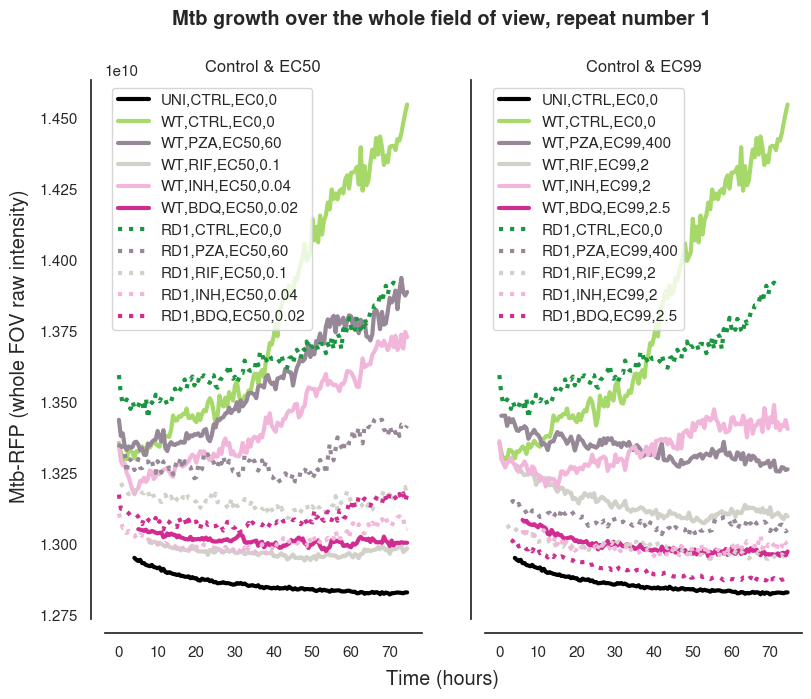

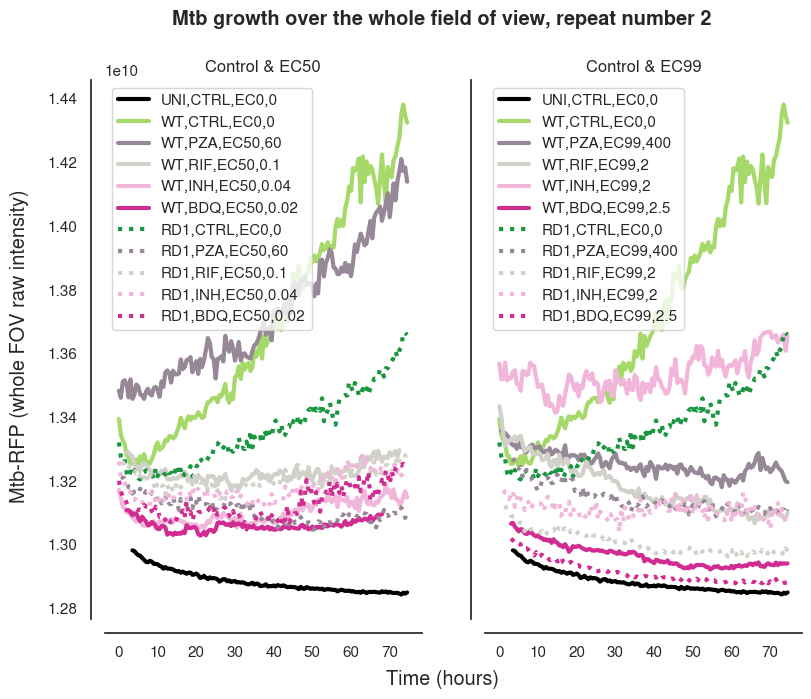

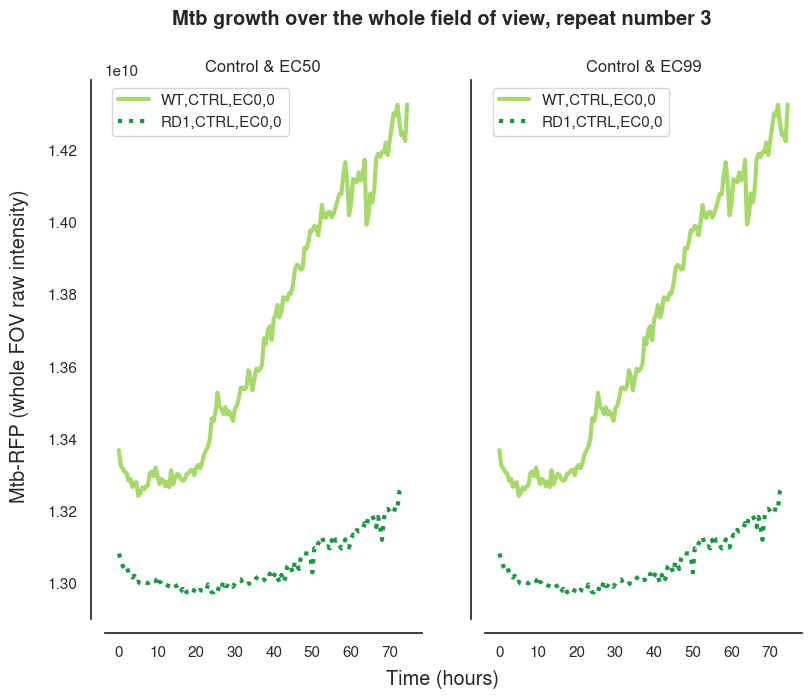

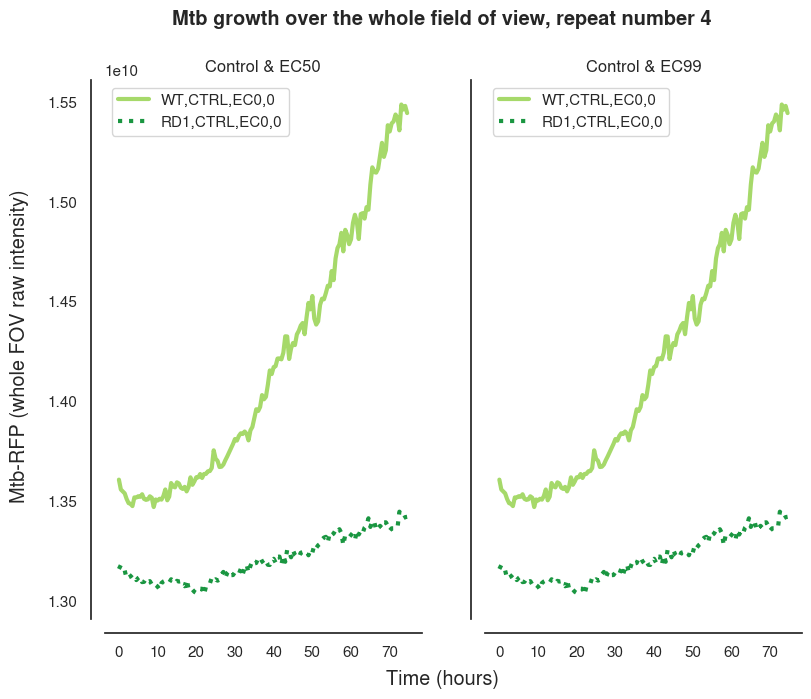

In [422]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wRD1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/168825270.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


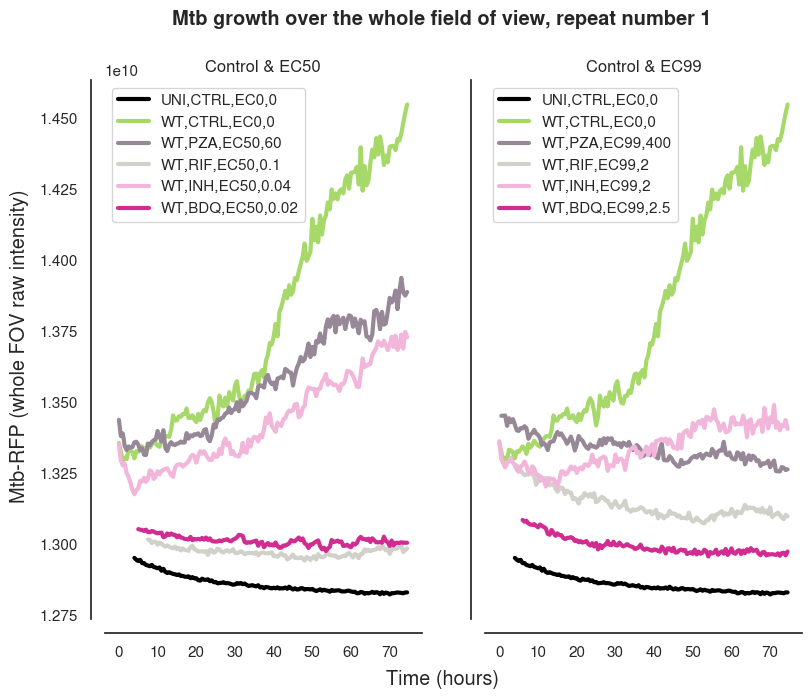

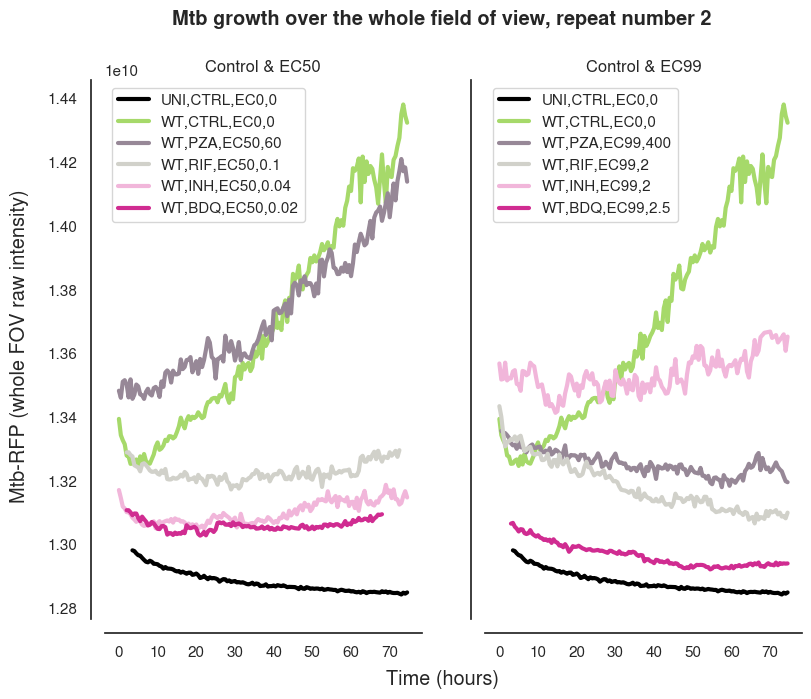

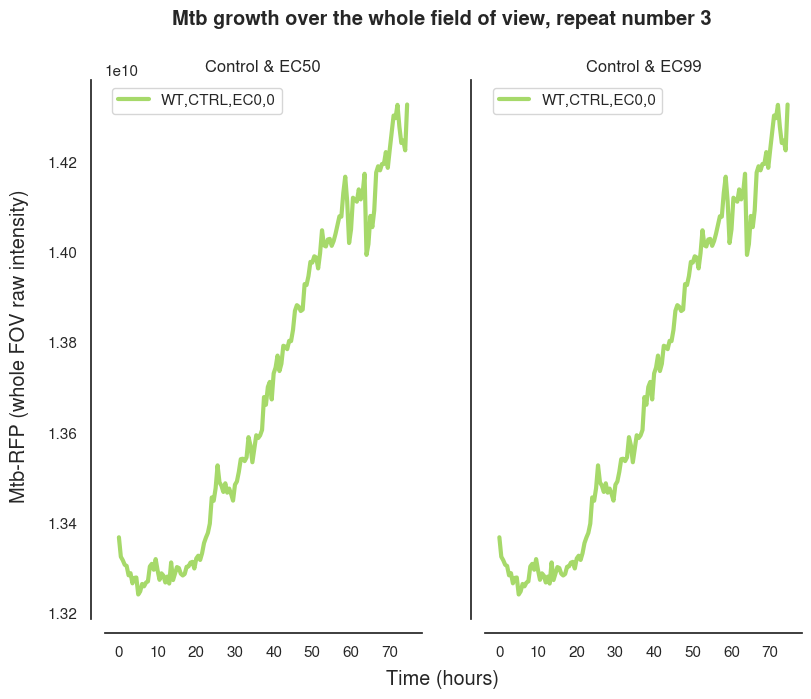

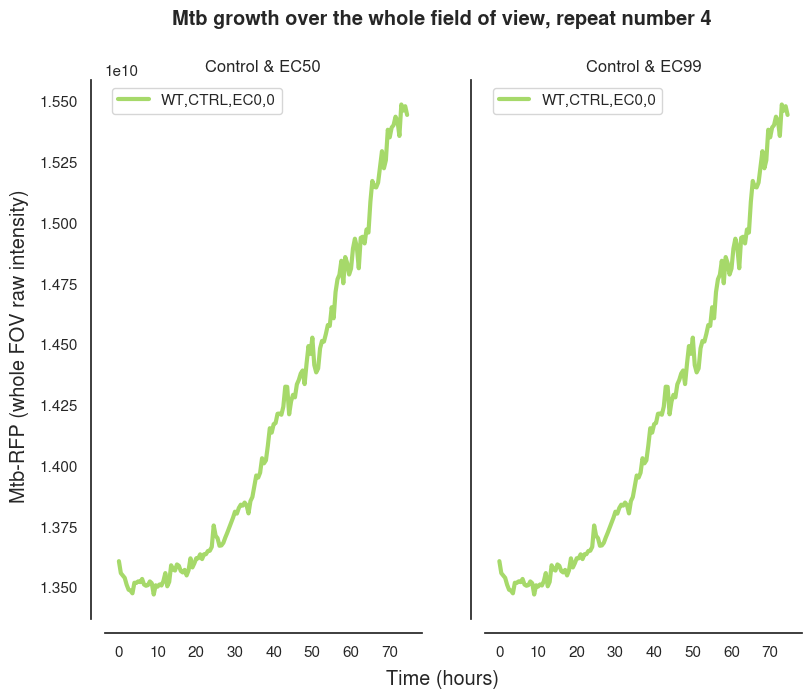

In [423]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]

            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain == 'RD1':
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)
    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/3068862412.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


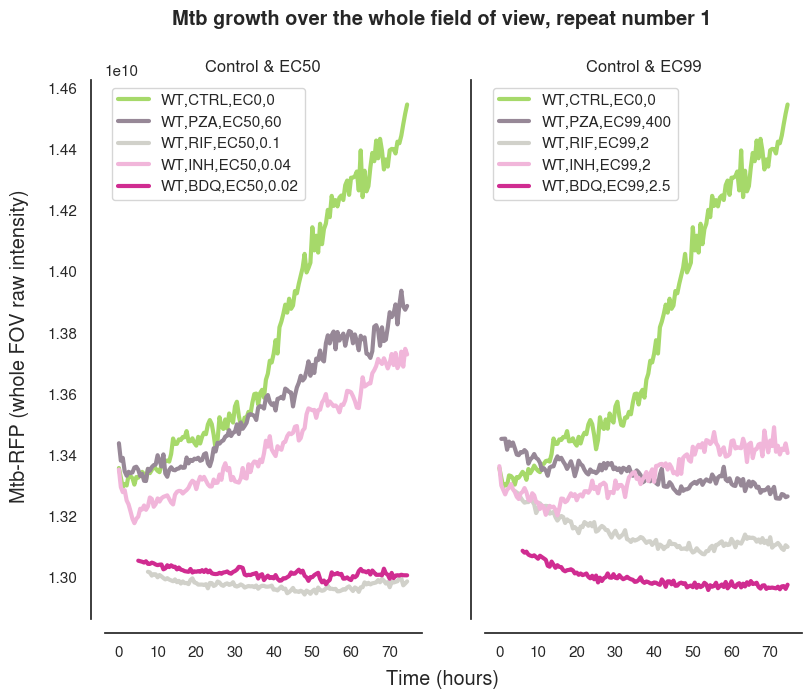

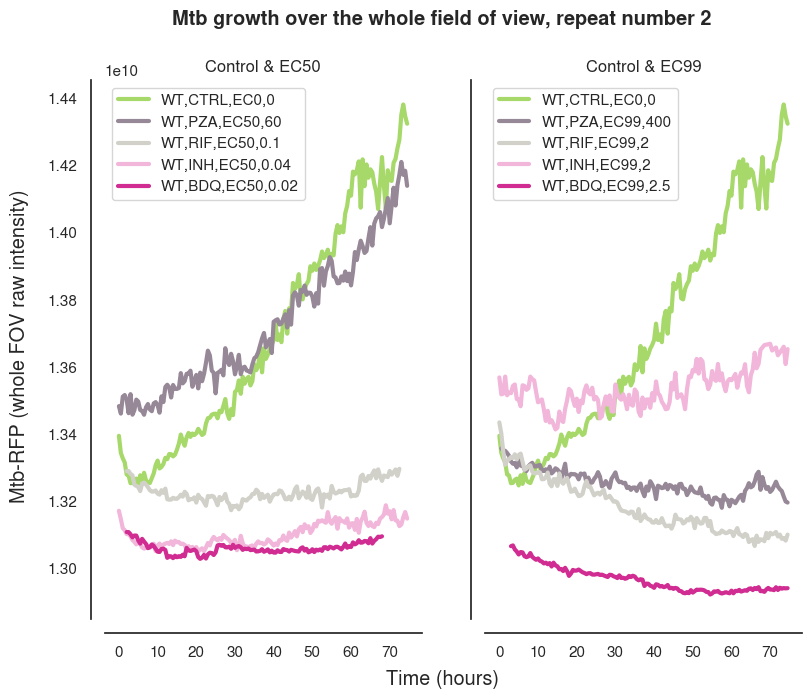

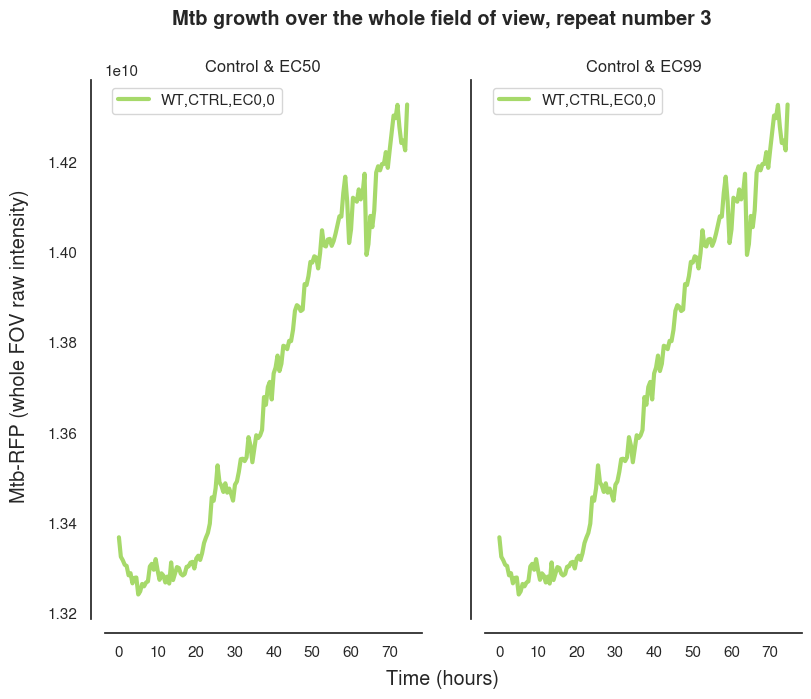

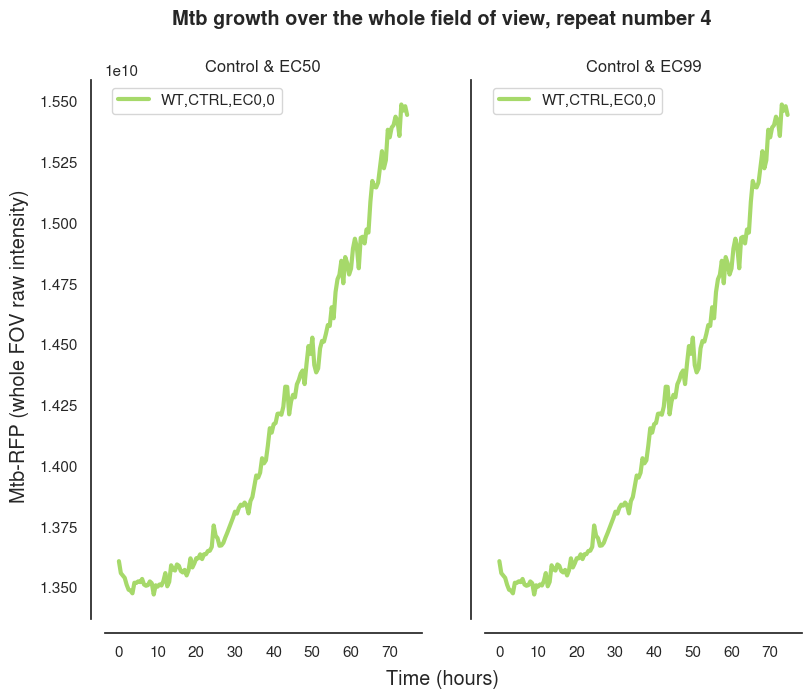

In [424]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['RD1', 'UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_word1_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/tmp/ipykernel_1217616/1349372992.py:68: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


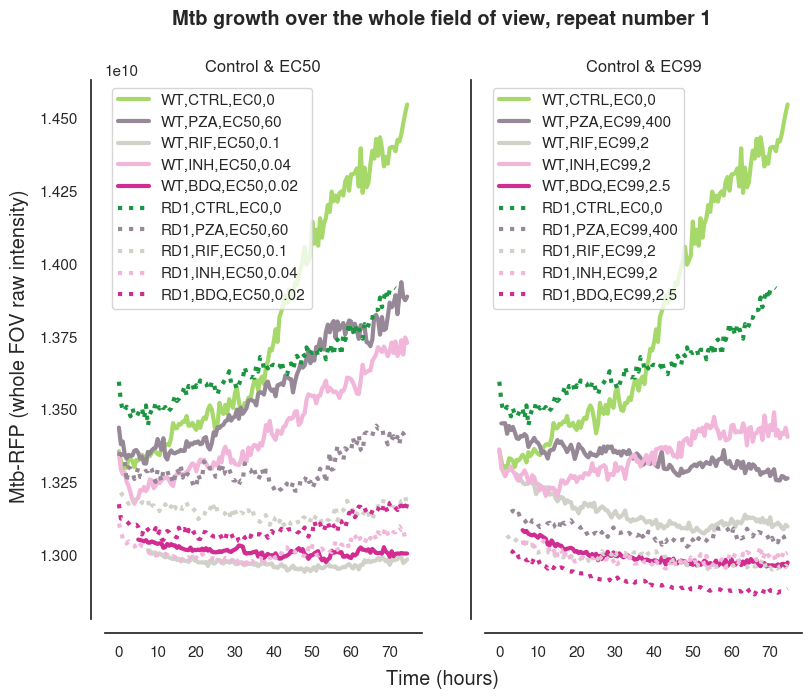

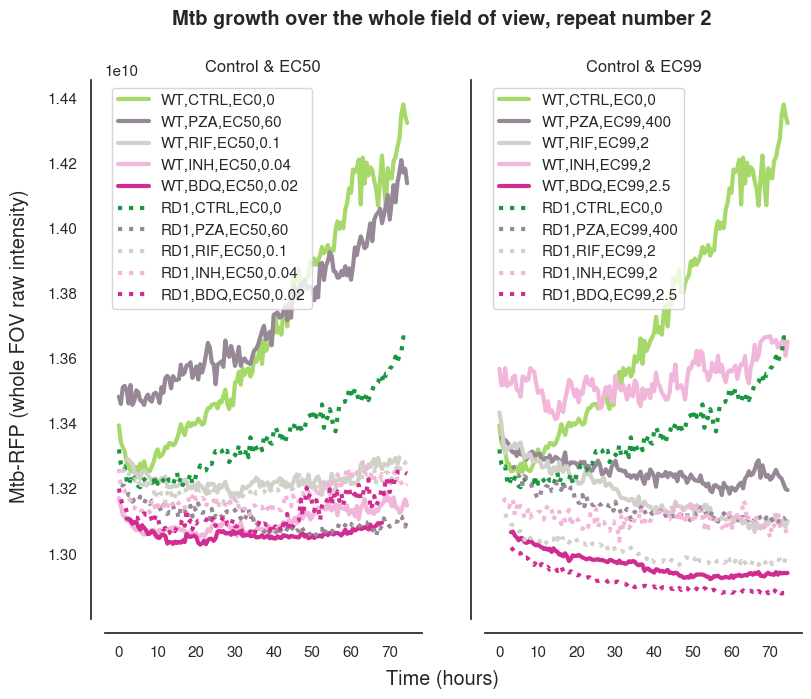

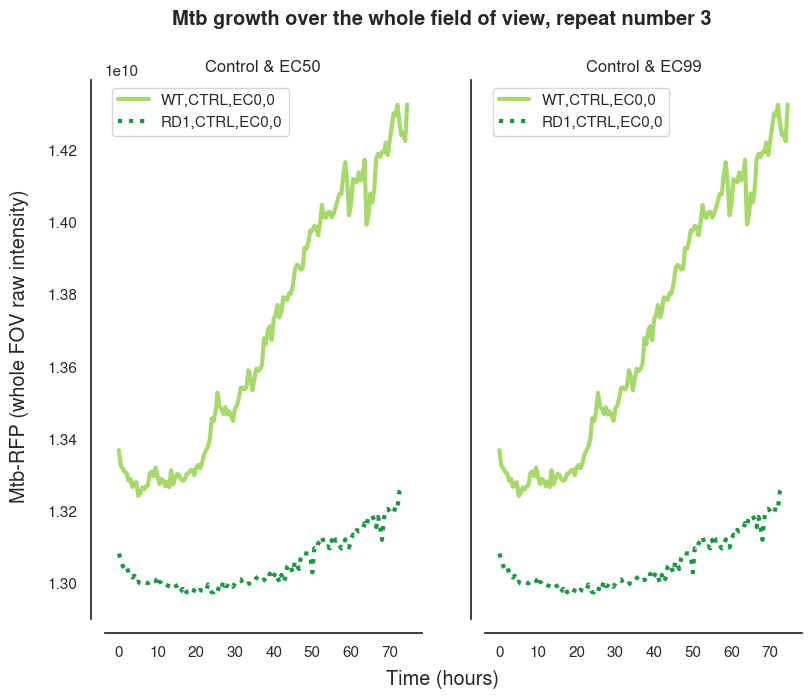

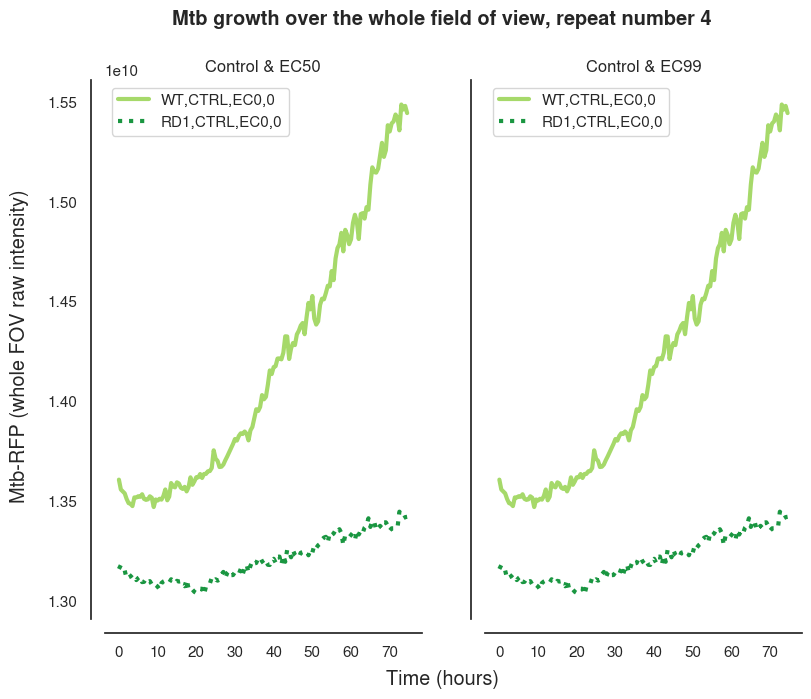

In [425]:
sns.set_palette(expanded_piyg.colors)
# fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))


for repeat_num in assay_layout['Technical repeat'].unique():
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))

    assay_layout_repeat = assay_layout[assay_layout['Technical repeat'] == repeat_num]
    for (row, column), info in assay_layout_repeat.iterrows():
        # if info['Strain'] == 'UNI':
        #     continue
        if info['ConcentrationEC']  in ['EC0', 'EC50']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            LHS = sns.lineplot(data=cleaned_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour)

        if info['ConcentrationEC']  in ['EC0', 'EC99']:
            ### seperate data
            index = (row, column)
            ### plot EC50 on the LHS
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            strain = info['Strain']
            if strain in ['UNI']:
                continue
            comp = info['Compound']
            conc = info['Concentration']
            ec_conc = info['ConcentrationEC']
            label = f'{strain},{comp},{ec_conc},{conc}' 
            colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
            if strain == 'RD1':
                linestyle = ':'
            else:
                linestyle = '-'
            RHS = sns.lineplot(data=cleaned_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour)

    LHS.set(ylabel=None)
    # Update x-axis labels to represent 30-minute intervals
    x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
    x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
    plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])
    
    # Add subtitles above each graph
    ax[0].set_title("Control & EC50")
    ax[1].set_title("Control & EC99")
    
    plt.ylabel('')
    fig.supxlabel('Time (hours)')
    fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
    plt.suptitle(f'Mtb growth over the whole field of view, repeat number {repeat_num}', fontweight='bold')
    sns.despine(offset=10)

    plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_wo_uni_atbs_repeat{repeat_num}.png'), bbox_inches='tight', dpi=314)

    fig.show()



### Plotting repeats overlaid

In [450]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [449]:
assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates()

Strain Compound Concentration ConcentrationEC
Row Column                                              
3   1         UNI     CTRL             0             EC0
    3          WT     CTRL             0             EC0
    5          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    9          WT      INH          0.04            EC50
    11         WT      BDQ          0.02            EC50
4   5          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    9          WT      INH             2            EC99
    11         WT      BDQ           2.5            EC99
5   3         RD1     CTRL             0             EC0
    5         RD1      PZA            60            EC50
    7         RD1      RIF           0.1            EC50
    9         RD1      INH          0.04            EC50
    11        RD1      BDQ          0.02            EC50
6   5         RD1      PZA           400            EC99
    7         RD1      RIF             2            EC99
    9         RD1      INH             2            EC99
    11        RD1      BDQ           2.5            EC99

In [451]:
for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    print(info)


Strain              UNI
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 1), dtype: object
Strain               WT
Compound           CTRL
Concentration         0
ConcentrationEC     EC0
Name: (3, 3), dtype: object
Strain               WT
Compound            PZA
Concentration        60
ConcentrationEC    EC50
Name: (3, 5), dtype: object
Strain               WT
Compound            RIF
Concentration       0.1
ConcentrationEC    EC50
Name: (3, 7), dtype: object
Strain               WT
Compound            INH
Concentration      0.04
ConcentrationEC    EC50
Name: (3, 9), dtype: object
Strain               WT
Compound            BDQ
Concentration      0.02
ConcentrationEC    EC50
Name: (3, 11), dtype: object
Strain               WT
Compound            PZA
Concentration       400
ConcentrationEC    EC99
Name: (4, 5), dtype: object
Strain               WT
Compound            RIF
Concentration         2
ConcentrationEC    EC99
Name: (4, 7), dtype: object
Strain 

In [453]:
assay_layout

Strain Compound Concentration ConcentrationEC  Technical repeat
Row Column                                                                
3   1         UNI     CTRL             0             EC0                 1
    2         UNI     CTRL             0             EC0                 2
    3          WT     CTRL             0             EC0                 1
    4          WT     CTRL             0             EC0                 2
    5          WT      PZA            60            EC50                 1
    6          WT      PZA            60            EC50                 2
    7          WT      RIF           0.1            EC50                 1
    8          WT      RIF           0.1            EC50                 2
    9          WT      INH          0.04            EC50                 1
    10         WT      INH          0.04            EC50                 2
    11         WT      BDQ          0.02            EC50                 1
    12         WT      BDQ          0.02            EC50                 2
4   3          WT     CTRL             0             EC0                 3
    4          WT     CTRL             0             EC0                 4
    5          WT      PZA           400            EC99                 1
    6          WT      PZA           400            EC99                 2
    7          WT      RIF             2            EC99                 1
    8          WT      RIF             2            EC99                 2
    9          WT      INH             2            EC99                 1
    10         WT      INH             2            EC99                 2
    11         WT      BDQ           2.5            EC99                 1
    12         WT      BDQ           2.5            EC99                 2
5   3         RD1     CTRL             0             EC0                 1
    4         RD1     CTRL             0             EC0                 2
    5         RD1      PZA            60            EC50                 1
    6         RD1      PZA            60            EC50                 2
    7         RD1      RIF           0.1            EC50                 1
    8         RD1      RIF           0.1            EC50                 2
    9         RD1      INH          0.04            EC50                 1
    10        RD1      INH          0.04            EC50                 2
    11        RD1      BDQ          0.02            EC50                 1
    12        RD1      BDQ          0.02            EC50                 2
6   3         RD1     CTRL             0             EC0                 3
    4         RD1     CTRL             0             EC0                 4
    5         RD1      PZA           400            EC99                 1
    6         RD1      PZA           400            EC99                 2
    7         RD1      RIF             2            EC99                 1
    8         RD1      RIF             2            EC99                 2
    9         RD1      INH             2            EC99                 1
    10        RD1      INH             2            EC99                 2
    11        RD1      BDQ           2.5            EC99                 1
    12        RD1      BDQ           2.5            EC99                 2

In [473]:
cleaned_series

0             1             2             3    \
Row Column                                                           
6   11      1.310772e+10  1.308648e+10  1.307119e+10  1.305876e+10   
    12      1.311994e+10  1.309136e+10  1.305267e+10  1.304545e+10   

                     4             5             6             7    \
Row Column                                                           
6   11      1.304037e+10  1.304033e+10  1.301729e+10  1.301309e+10   
    12      1.304272e+10  1.302610e+10  1.301955e+10  1.301408e+10   

                     8             9    ...           140           141  \
Row Column                              ...                               
6   11      1.299978e+10  1.300731e+10  ...  1.287938e+10  1.287871e+10   
    12      1.300614e+10  1.300051e+10  ...  1.288578e+10  1.287866e+10   

                     142           143           144           145  \
Row Column                                                           
6   11      1.288302e+10  1.287753e+10  1.287248e+10  1.287729e+10   
    12      1.288287e+10  1.289255e+10  1.288116e+10  1.288207e+10   

                     146           147           148           149  
Row Column                                                          
6   11      1.287703e+10  1.287929e+10  1.288263e+10  1.288682e+10  
    12      1.287799e+10  1.288075e+10  1.288131e+10  1.288176e+10  

[2 rows x 150 columns]

In [470]:
assay_layout['Technical repeat'].unique()

array([1, 2, 3, 4])

In [484]:
concat_series

8      1.295410e+10
9      1.294740e+10
10     1.294297e+10
11     1.294719e+10
12     1.293553e+10
           ...     
145    1.284703e+10
146    1.284426e+10
147    1.284991e+10
148    1.284697e+10
149    1.285080e+10
Length: 285, dtype: float64

/tmp/ipykernel_1217616/2323974640.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


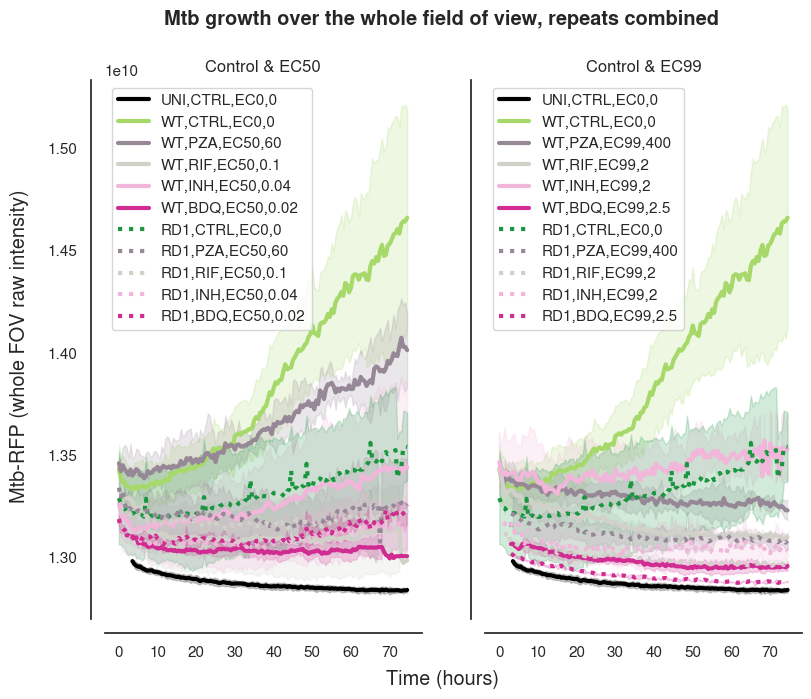

In [498]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3755018027.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


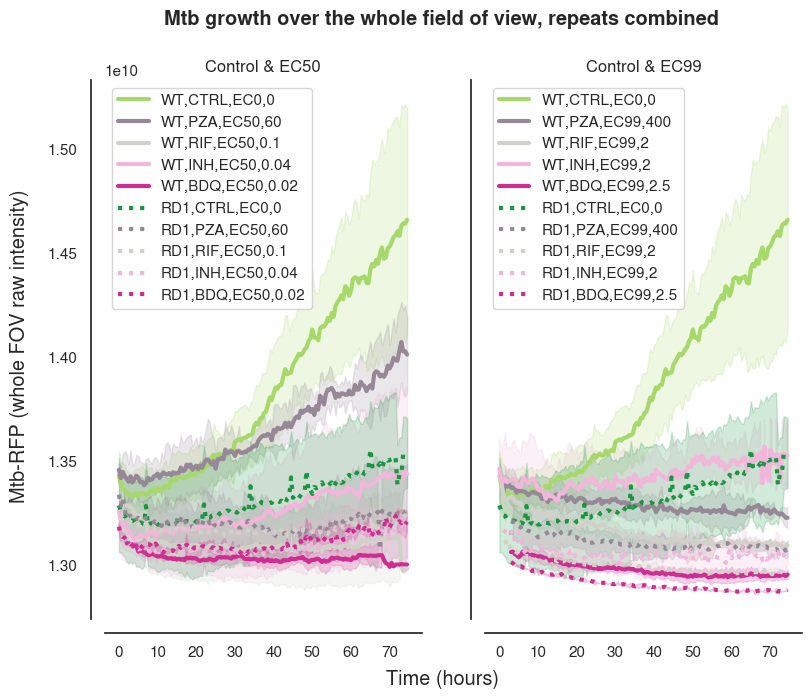

In [499]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/3533890359.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


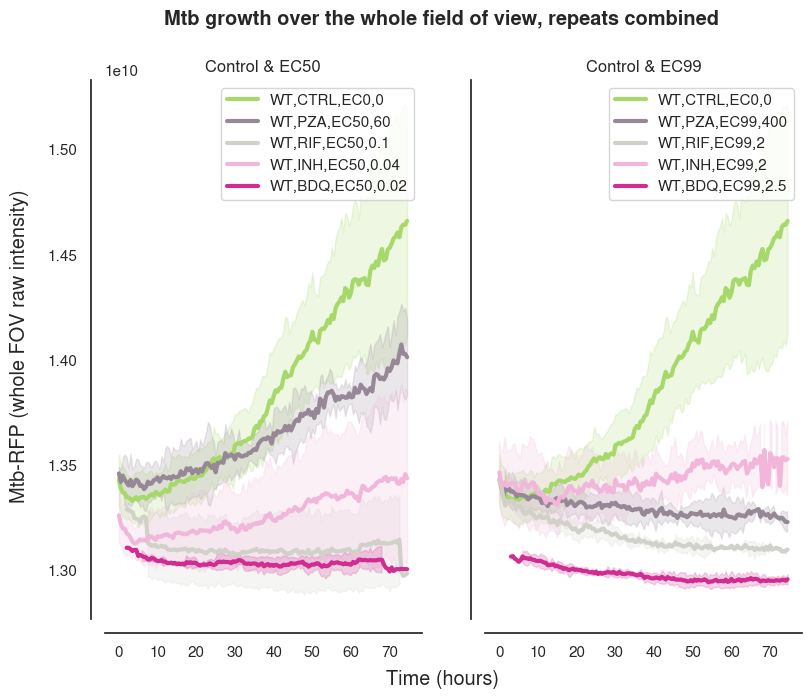

In [500]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['UNI', 'RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_uni_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()



/tmp/ipykernel_1217616/235941939.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


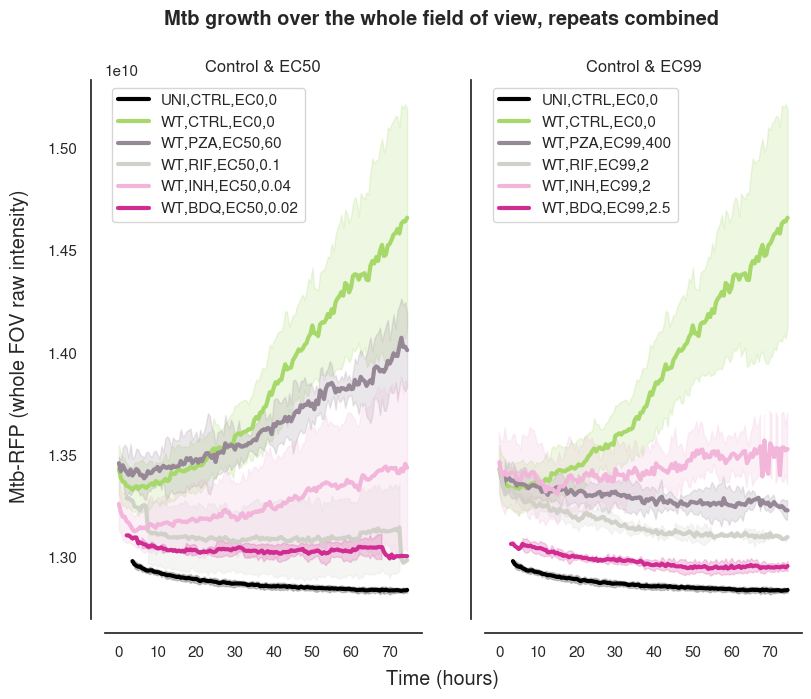

In [501]:
sns.set_palette(expanded_piyg.colors)
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(9, 7))
concat_cond_dict = {}

for (row, column), info in assay_layout[['Strain', 'Compound', 'Concentration', 'ConcentrationEC']].drop_duplicates().iterrows():

    if info['Strain'] in ['RD1']:
            continue
    
    if info['ConcentrationEC']  in ['EC0', 'EC50']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        LHS = sns.lineplot(data=concat_series, ax=ax[0], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
        
    if info['ConcentrationEC']  in ['EC0', 'EC99']:
        strain = info['Strain']
        # if strain in ['UNI']:
        #     continue
        comp = info['Compound']
        conc = info['Concentration']
        ec_conc = info['ConcentrationEC']
        label = f'{strain},{comp},{ec_conc},{conc}' 
        concat_cond_dict[label] = {}
        colour = colour_map_dict[comp] if comp in colour_map_dict.keys() else colour_map_dict[strain]
    
        
        indices = assay_layout[(assay_layout['Compound'] == comp) & 
                                   (assay_layout['Concentration'] == conc) & 
                                   (assay_layout['ConcentrationEC'] == ec_conc) &
                                   (assay_layout['Strain'] == strain)].index
        concat_series = []
        for index in indices:
            cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            concat_series.append(cleaned_series)
        concat_series = pd.concat(concat_series)
        # for repeat_num in assay_layout['Technical repeat'].unique():
    
        #     indices = assay_layout[(assay_layout['Compound'] == comp) & 
        #                            (assay_layout['Concentration'] == conc) & 
        #                            (assay_layout['ConcentrationEC'] == ec_conc) &
        #                            (assay_layout['Strain'] == strain)].index
            
            # concat_series = []
            # for index in indices:
            #     cleaned_series = remove_outliers_iqr(rfp_df.T.loc[index])
            #     concat_series.append(cleaned_series)
            # concat_series = pd.concat(concat_series)
            
        if strain == 'RD1':
            linestyle = ':'
        else:
            linestyle = '-'
        RHS = sns.lineplot(data=concat_series, ax=ax[1], label=label, linewidth=3, linestyle=linestyle, color = colour, ci = 'sd')
   
    
LHS.set(ylabel=None)
# Update x-axis labels to represent 30-minute intervals
x_labels = [str(int(i*0.5)) for i in range(len(rfp_df.T.columns))]
x_ticks = range(0, len(rfp_df.T.columns), 20)  # Display every 5 time points
plt.xticks(x_ticks, [x_labels[i] for i in x_ticks])

# Add subtitles above each graph
ax[0].set_title("Control & EC50")
ax[1].set_title("Control & EC99")

plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle(f'Mtb growth over the whole field of view, repeats combined', fontweight='bold')
sns.despine(offset=10)

plt.savefig(os.path.join(output_dir, f'whole_fov_mtb_growth_atbs_combined_wo_rd1.png'), bbox_inches='tight', dpi=314)

fig.show()

